# Preparation

## Imports

In [1]:
# Data handling
import pandas as pd
import numpy as np
# Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
# Statistical analyses
import itertools
from scipy.stats import norm, truncnorm, gaussian_kde
from scipy.stats import ks_2samp, pearsonr
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statistics import NormalDist
# IO
import sys
import os
# Tensorflow
import tensorflow as tf

## Paths

In [2]:
# Base path for functions
base_path = "C:/repos/"
sys.path.append(base_path)

# Path to find run results
results_path = base_path + "twrds_unbiased_anns/runs/results/"

# Path to store figures
figure_path = base_path + "twrds_unbiased_anns/figures/results/grad/"

# Model path
model_path = base_path + "twrds_unbiased_anns/runs/grad_fair_selection_easier/checkpoints/"

## Functions

In [3]:
# Evaluation
from twrds_unbiased_anns.src.data.eval import load_eval_samples, evaluate_performance, evaluate_performance_class, evaluate_model, store_results

# Custom functions
from twrds_unbiased_anns.src.tf.models import grad_reverse, GradReverse

# Analysis - Candidate Histograms

In [4]:
# Disable warnings when loading models
tf.get_logger().setLevel('ERROR')

# Load evaluation sample
eval_sample_filename = "eval_500_mean_100_std_20.data"
colors = ["red"]
eval_samples = load_eval_samples(base_path + "twrds_unbiased_anns/data/eval/" + eval_sample_filename)

# Create empty list of all results
eval_results = []

# List of candidates
#candidates = os.listdir(model_path)
candidates = ["grad_fair_1_3_31", "grad_fair_1_3_35"]

for candidate in candidates:
    # Get information on model
    info = candidate.split("_")
    # Create dictionary with model information
    row = {
        "modelname": candidate,
        "lambda_val": info[2],
        "repeat": info[3],
        "epoch": info[4]
    } 
    # Load candidate model
    model = tf.keras.models.load_model(model_path + candidate)
    # Evaluate model
    evaluate_model(model, eval_samples, row, eval_results, colors) 
    
# Make dataframe of results
df = pd.DataFrame(eval_results)
df

,modelname,lambda_val,repeat,epoch,shape_color,shape_type,actual,prediction,color_prediction,shape_prediction
0,grad_fair_1_3_31,1,3,31,white,square,115,163.398697,1.0,1.0
1,grad_fair_1_3_31,1,3,31,white,square,127,62.323986,1.0,1.0
2,grad_fair_1_3_31,1,3,31,white,square,113,164.464127,1.0,0.0
3,grad_fair_1_3_31,1,3,31,white,square,107,127.038338,1.0,0.0
4,grad_fair_1_3_31,1,3,31,white,square,92,72.051521,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
995,grad_fair_1_3_35,1,3,35,colorful,circle,77,94.043709,1.0,1.0
996,grad_fair_1_3_35,1,3,35,colorful,circle,84,102.571053,1.0,1.0
997,grad_fair_1_3_35,1,3,35,colorful,circle,102,100.965096,1.0,1.0
998,grad_fair_1_3_35,1,3,35,colorful,circle,108,116.147713,1.0,1.0


## Prediction Accuracy of Protected Attributes

In [5]:
# Add columns with binary prediction
df["color_bin"] = df["color_prediction"] >= 0.5
df["shape_bin"] = df["shape_prediction"] >= 0.5

# Add columns for true positive, false positive, true negative, false negative
conditions_color = [
    (df['shape_color'] == "colorful") & (df['color_bin'] == 1),
    (df['shape_color'] == "white") & (df['color_bin'] == 1),
    (df['shape_color'] == "white") & (df['color_bin'] == 0),
    (df['shape_color'] == "colorful") & (df['color_bin'] == 0)
]

conditions_shape = [
    (df['shape_type'] == "circle") & (df['shape_bin'] == 1),
    (df['shape_type'] == "square") & (df['shape_bin'] == 1),
    (df['shape_type'] == "square") & (df['shape_bin'] == 0),
    (df['shape_type'] == "circle") & (df['shape_bin'] == 0)
]

# Create a list of the values we want to assign for each condition
values = ['tp', 'fp', 'tn', 'fn']

# Create a new column and use np.select to assign values to it using our lists as arguments
df['result_color'] = np.select(conditions_color, values)
df['result_shape'] = np.select(conditions_shape, values)

df

,modelname,lambda_val,repeat,epoch,shape_color,shape_type,actual,prediction,color_prediction,shape_prediction,color_bin,shape_bin,result_color,result_shape
0,grad_fair_1_3_31,1,3,31,white,square,115,163.398697,1.0,1.0,True,True,fp,fp
1,grad_fair_1_3_31,1,3,31,white,square,127,62.323986,1.0,1.0,True,True,fp,fp
2,grad_fair_1_3_31,1,3,31,white,square,113,164.464127,1.0,0.0,True,False,fp,tn
3,grad_fair_1_3_31,1,3,31,white,square,107,127.038338,1.0,0.0,True,False,fp,tn
4,grad_fair_1_3_31,1,3,31,white,square,92,72.051521,1.0,0.0,True,False,fp,tn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,grad_fair_1_3_35,1,3,35,colorful,circle,77,94.043709,1.0,1.0,True,True,tp,tp
996,grad_fair_1_3_35,1,3,35,colorful,circle,84,102.571053,1.0,1.0,True,True,tp,tp
997,grad_fair_1_3_35,1,3,35,colorful,circle,102,100.965096,1.0,1.0,True,True,tp,tp
998,grad_fair_1_3_35,1,3,35,colorful,circle,108,116.147713,1.0,1.0,True,True,tp,tp


In [6]:
def get_results(data, result_col):
    total = len(data)
    tp = len(data[data[result_col] == "tp"])
    fp = len(data[data[result_col] == "fp"])
    tn = len(data[data[result_col] == "tn"])
    fn = len(data[data[result_col] == "fn"])
    p = tp + fn
    n = tn + fp
    accuracy = (tp + tn) / total
    tpr = tp / p
    tnr = tn / n
    return total, accuracy, tpr, tnr

In [11]:
for model in candidates:
    for attribute in ["color", "shape"]:
        data = df[df.modelname == model]
        avg = data[attribute + "_prediction"].mean()
        total, accuracy, tpr, tnr = get_results(data, result_col = "result_" + attribute)
        print("Model: {}, Attribute: {}, Avg: {}, Accuracy: {}, TPR: {}, TNR: {}".format(model, attribute, avg, accuracy, tpr, tnr))

Model: grad_fair_1_3_31, Attribute: color, Avg: 0.884, Accuracy: 0.492, TPR: 0.876, TNR: 0.108
Model: grad_fair_1_3_31, Attribute: shape, Avg: 0.07896793370699579, Accuracy: 0.422, TPR: 0.0, TNR: 0.844
Model: grad_fair_1_3_35, Attribute: color, Avg: 1.0, Accuracy: 0.5, TPR: 1.0, TNR: 0.0
Model: grad_fair_1_3_35, Attribute: shape, Avg: 1.0, Accuracy: 0.5, TPR: 1.0, TNR: 0.0


## Histograms

In [41]:
df["category"] = "color"
df["prediction_diff"] = df['prediction'] - df['actual']
df["rmse"] = np.sqrt(df["prediction_diff"] * df["prediction_diff"])

conditions = [
    (df['category'] == 'color') & (df['shape_color'] == 'white'),
    (df['category'] == 'color') & (df['shape_color'] == 'colorful'),
    (df['category'] == 'shape') & (df['shape_type'] == 'square'),
    (df['category'] == 'shape') & (df['shape_type'] == 'circle')
]

# Create a list of the values we want to assign for each condition
values = ['over', 'under', 'over', 'under']

# create a new column and use np.select to assign values to it using our lists as arguments
df['group'] = np.select(conditions, values)

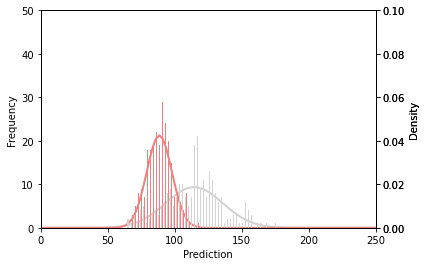

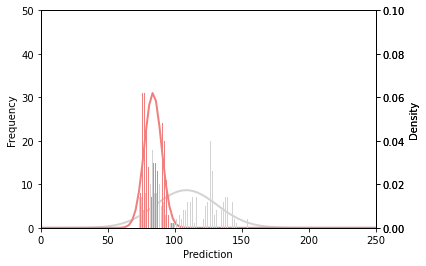

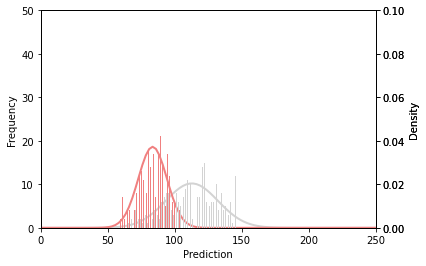

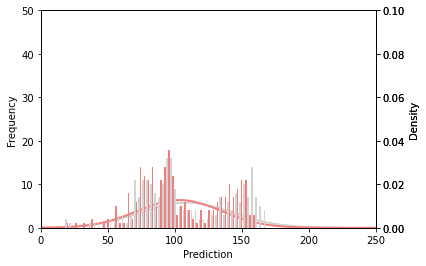

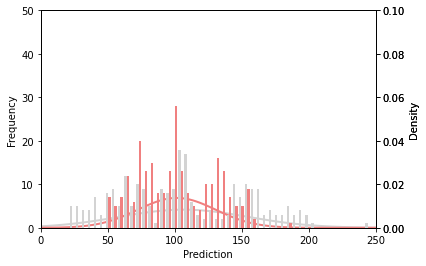

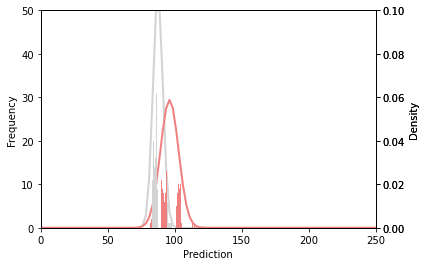

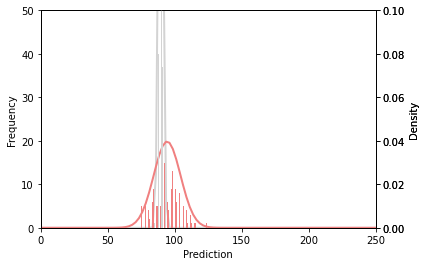

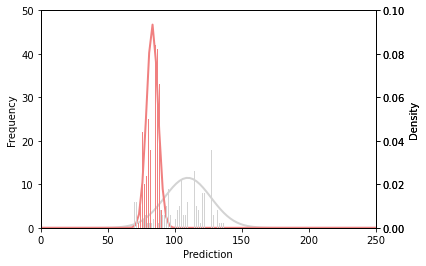

In [35]:
# Set colors
colors = ["lightgrey", "lightcoral"]
xlim = (0, 250)
ylim = (0, 50)

for candidate in os.listdir(model_path):
    # Filter data for model
    model_data = df[df.modelname == candidate].copy(deep = True)

    # Get predictions
    data = [model_data[model_data.shape_color == "white"].prediction, model_data[model_data.shape_color == "colorful"].prediction]     
    # Fit normal distribution
    mu_1, std_1 = norm.fit(data[0])
    mu_2, std_2 = norm.fit(data[1])

    # Create plot
    fig = plt.plot(figsize=(10,3.75))
    ax = plt.gca()      
    # Plot histogram    
    ax.hist(data, color = colors, bins = 50)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_ylabel('Frequency')  
    ax.set_xlabel('Prediction')

    # # Calculate ylim of second axis based on first axis      
    ylim_max_1 = ax.get_ylim()[1]
    ylim_max_2 = ylim_max_1 / (data[0].size + data[1].size)   

    # Plot distribution curve
    for cat_data, color in zip(data, colors):
        # Fit a normal distribution to the data
        mu, std = norm.fit(cat_data)
        # Calculate PDF
        xmin, xmax = xlim
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        # Plot PDF
        ax2 = ax.twinx()
        ax2.plot(x, p, color = color, linewidth = 2)
        ax2.set_ylim([0, ylim_max_2])  
        ax2.set_ylabel('Density')    
        # Fix plot display order
        ax.set_zorder(ax2.get_zorder()+1)
        ax.patch.set_visible(False)
    
    # Save plot
    plt.savefig(figure_path + "hist_" + candidate + ".png", dpi = 200, bbox_inches = 'tight')
    
    # Show plot
    plt.show()

# Analysis - Regression (Single Attribute) 

## Evaluation

In [45]:
# Name of best performing model
best_model = "grad_fair_1_3_35"
df_model = df[df.modelname == best_model].copy(deep = True)
df_model

,modelname,lambda_val,repeat,epoch,shape_color,shape_type,actual,prediction,color_prediction,shape_prediction,category,prediction_diff,rmse,group
2000,grad_fair_1_3_35,1,3,35,white,square,115,193.164322,1.0,1.0,color,78.164322,78.164322,over
2001,grad_fair_1_3_35,1,3,35,white,square,127,76.420174,1.0,1.0,color,-50.579826,50.579826,over
2002,grad_fair_1_3_35,1,3,35,white,square,113,182.126236,1.0,1.0,color,69.126236,69.126236,over
2003,grad_fair_1_3_35,1,3,35,white,square,107,104.142830,1.0,1.0,color,-2.857170,2.857170,over
2004,grad_fair_1_3_35,1,3,35,white,square,92,43.494881,1.0,1.0,color,-48.505119,48.505119,over
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,grad_fair_1_3_35,1,3,35,colorful,circle,77,94.759529,1.0,1.0,color,17.759529,17.759529,under
2496,grad_fair_1_3_35,1,3,35,colorful,circle,84,104.481209,1.0,1.0,color,20.481209,20.481209,under
2497,grad_fair_1_3_35,1,3,35,colorful,circle,102,95.614021,1.0,1.0,color,-6.385979,6.385979,under
2498,grad_fair_1_3_35,1,3,35,colorful,circle,108,116.719002,1.0,1.0,color,8.719002,8.719002,under


In [37]:
df_model.groupby(["shape_color", "shape_type"]).prediction.mean()

shape_color  shape_type
colorful     circle        109.428429
             square         93.406402
white        circle        119.690477
             square         93.494746
Name: prediction, dtype: float64

In [38]:
df_model.groupby(["shape_color", "shape_type"]).color_prediction.mean()

shape_color  shape_type
colorful     circle        1.0
             square        1.0
white        circle        1.0
             square        1.0
Name: color_prediction, dtype: float64

In [39]:
df_model.groupby(["shape_color", "shape_type"]).shape_prediction.mean()

shape_color  shape_type
colorful     circle        1.0
             square        1.0
white        circle        1.0
             square        1.0
Name: shape_prediction, dtype: float64

## Analysis

### Result Table

In [43]:
def get_results(data):
    avg_prediction = data.prediction.mean()
    avg_rmse = data.rmse.mean()
    return avg_prediction, avg_rmse

In [46]:
results = []
    
# Overall data
avg_prediction, avg_rmse = get_results(df_model)

# White shapes
white_shapes = df_model[df_model.group == "over"]
avg_prediction_w, avg_rmse_w = get_results(white_shapes)

# Red shapes
red_shapes = df_model[df_model.group == "under"]
avg_prediction_r, avg_rmse_r = get_results(red_shapes)

# Perform KS-Test
ks_stat, ks_p = ks_2samp(white_shapes.prediction, red_shapes.prediction)

# Store data
results.append(
    {            
        "count": df_model.shape[0],
        "avg_prediction_w": avg_prediction_w,
        "avg_prediction_r": avg_prediction_r,
        "avg_rmse_w": avg_rmse_w,
        "avg_rmse_r": avg_rmse_r,    
        "ks_stat": ks_stat,
        "ks_p": ks_p,
        "prediction_diff": avg_prediction_w - avg_prediction_r,
        "rmse_diff": avg_rmse_w - avg_rmse_r
    }
)
    
# Make dataframe of results
df_results = pd.DataFrame(results)
df_results

,count,avg_prediction_w,avg_prediction_r,avg_rmse_w,avg_rmse_r,ks_stat,ks_p,prediction_diff,rmse_diff
0,500,106.592612,101.417416,31.733692,17.988558,0.216,0.000016,5.175196,13.745134


In [48]:
0.000016

1.6e-05

In [47]:
1.60e-5

1.6e-05

In [15]:
def get_significance_string_latex(p_val, alpha_levels = [0.05, 0.01, 0.001, 0.0001]):
  if p_val <= alpha_levels[-1]:
    return "\\tnote{ ****}"
  elif p_val <= alpha_levels[-2]:
    return "\\tnote{ ***}"
  elif p_val <= alpha_levels[-3]:
    return "\\tnote{ **}"
  elif p_val <= alpha_levels[-4]:
    return "\\tnote{ *}"
  else:
    return ""  

def convert_p_val_to_str(p):
    # Get significance indicator
    sign_str = get_significance_string_latex(p)
    # Check if p is zero
    if p == 0.0:
        return "{:.4f} {}".format(p, sign_str)
    # Check if p value would be converted to exponent notation
    if p >= 0.0001:
        return "{:.4f} {}".format(p, sign_str)
    else:
        # Convert to times notation
        p_str = str(p)
        [pre, exp] = p_str.split('e')
        exp_number = int(exp[1:])
        if exp_number > 9:
            exp_str = "{{-{}}}".format(exp_number)
        else:
            exp_str = "{{-{}\\hphantom{{0}}}}".format(exp_number)
        return "${:.2f}\\times10^{}$ {}".format(float(pre), exp_str, sign_str)

def convert_val_to_str(val):
    # Check if value would be converted to exponent notation
    if val >= 0.0001:
        return "{:.4f}".format(val)
    elif val < -0.0001:
        return "{:.4f}".format(val)
    else:
        # Convert to times notation
        val_str = str(val)
        [pre, exp] = val_str.split('e')
        exp_number = int(exp[1:])
        if exp_number > 99:
            exp_str = "{{-{}}}".format(exp_number)
        elif exp_number > 9:
            exp_str = "{{-{}\\hphantom{{0}}}}".format(exp_number)
        else:
            exp_str = "{{-{}\\hphantom{{0}}\\hphantom{{0}}}}".format(exp_number)
        return "${:.2f}\\times10^{}$".format(float(pre), exp_str)
        
def convert_p_val_for_table(p):
    # Check if p is zero
    if p == 0.0:
        return "{:.4f}".format(p)
    # Check if p value would be converted to exponent notation
    if p >= 0.0001:
        return "{:.4f}".format(p)
    else:
        # Convert to times notation
        p_str = str(p)
        [pre, exp] = p_str.split('e')
        return "{:.2f}e{}".format(float(pre), exp)    

def print_data(data):
    for index, row in data.iterrows():
        category = row["category"]
        attr_loss_weight = row["attr_loss_weight"]        
        mean_w = round(row["avg_prediction_w"],2)        
        rmse_w = round(row["avg_rmse_w"],2)
        mean_r = round(row["avg_prediction_r"],2)
        rmse_r = round(row["avg_rmse_r"],2)
        ks_stat = round(row["ks_stat"], 2)
        if row["ks_p"] != 0.0:
            ks_p = convert_p_val_to_str(row["ks_p"])
        else:
            ks_p = "0.0000"
        ks_p_alt = convert_p_val_for_table(row["ks_p"])
        row_text = "{} & {:.0f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f}".format(category, attr_loss_weight, mean_w, rmse_w, mean_r, rmse_r, ks_stat)
        print(row_text + "& " + str(ks_p_alt) + get_significance_string_latex(row["ks_p"]) + " \\\\")
        
def print_to_latex(data):         
    # Print data only
    print_data(data)      

In [20]:
print_to_latex(df_results)


% Results of 1st experiment
\renewcommand{\arraystretch}{1}
\begin{table}[h!]
\centering
\renewcommand*\TPTnoteLabel[1]{\parbox[b]{3em}{\hfill#1\,}}
\begin{threeparttable}
\begin{tabular*}{\textwidth}{SSS @{\extracolsep{\fill}} SSSSSS[table-format=1.2e-2, table-align-text-post = false, table-space-text-post = \tnote{ **** }] @{\extracolsep{\fill}}}
\toprule
&&& \multicolumn{2}{c}{White Shapes} & \multicolumn{2}{c}{Red Shapes} & \multicolumn{2}{c}{KS Test} \\
\cmidrule(l{2pt}r{2pt}){4-5}
\cmidrule(l{2pt}r{2pt}){6-7}
\cmidrule(l{2pt}r{2pt}){8-9}
{$\sigma$} & {$\mathrm{\%}_{\mathrm{red}}$} & {$\mu$} & {Pred.} & {RMSE} & {Pred.} & {RMSE} & {$d_{\mathrm{n}}$} & {$p$-value} \\ \midrule

color & 10 & 100.44 & 1.76 & 72.99 & 27.44 & 0.70& 3.76e-293\tnote{ ****} \\
color & 100 & 100.14 & 1.39 & 94.49 & 35.35 & 0.39& 5.17e-85\tnote{ ****} \\
color & 1000 & 97.00 & 6.16 & 46.46 & 53.98 & 0.79& 0.0000\tnote{ ****} \\
shape & 10 & 100.84 & 2.07 & 88.90 & 11.55 & 0.34& 6.77e-63\tnote{ ****} \\
shap

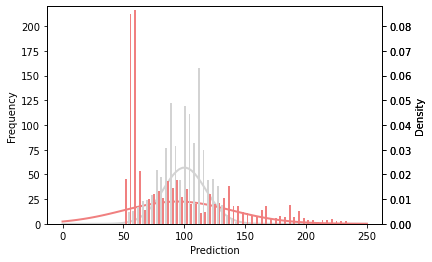

In [34]:
df_filtered = df[df.category == "color"].copy(deep = True)
df_filtered = df_filtered[df_filtered["attr_loss_weight"] == 100].copy(deep = True)

# Get predictions
data = [df_filtered[df_filtered.group == "over"].prediction, df_filtered[df_filtered.group == "under"].prediction]     
# Fit normal distribution
mu_1, std_1 = norm.fit(data[0])
mu_2, std_2 = norm.fit(data[1])

# Create plot
fig = plt.plot(figsize=(10,3.75))
ax = plt.gca()      
# Plot histogram
ax.hist(data, color = colors, bins = 50)
#ax.set_xlim(0,150)
#ax.set_ylim(0,150)
ax.set_ylabel('Frequency')  
ax.set_xlabel('Prediction')



# Plot distribution curve
for cat_data, color in zip(data, colors):
    # Fit a normal distribution to the data
    mu, std = norm.fit(cat_data)
    # Calculate PDF
    xmin, xmax = 0, 250
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    # Plot PDF
    ax2 = ax.twinx()
    ax2.plot(x, p, color = color, linewidth = 2)
    ax.set_ylim([0,220])
    # Calculate ylim of second axis based on first axis      
    ylim_max_1 = ax.get_ylim()[1]
    ylim_max_2 = ylim_max_1 / (data[0].size + data[1].size)   
    ax2.set_ylim([0, ylim_max_2])  
    ax2.set_ylabel('Density')    
    # Fix plot display order
    ax.set_zorder(ax2.get_zorder()+1)
    ax.patch.set_visible(False)

plt.savefig(figure_path + "hist_color_100_1", dpi = 200, bbox_inches = 'tight')
plt.show()


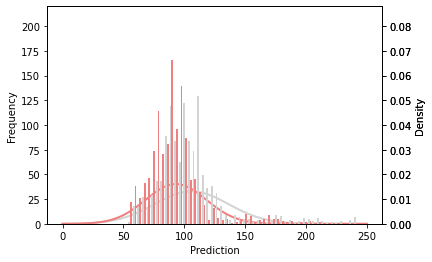

In [37]:
df_filtered = df[df.category == "shape"].copy(deep = True)
df_filtered = df_filtered[df_filtered["attr_loss_weight"] == 100].copy(deep = True)

# Get predictions
data = [df_filtered[df_filtered.group == "over"].prediction, df_filtered[df_filtered.group == "under"].prediction]     
# Fit normal distribution
mu_1, std_1 = norm.fit(data[0])
mu_2, std_2 = norm.fit(data[1])

# Create plot
fig = plt.plot(figsize=(10,3.75))
ax = plt.gca()      
# Plot histogram
ax.hist(data, color = colors, bins = 50)
#ax.set_xlim(0,150)
#ax.set_ylim(0,150)
ax.set_ylabel('Frequency')  
ax.set_xlabel('Prediction')

# Plot distribution curve
for cat_data, color in zip(data, colors):
    # Fit a normal distribution to the data
    mu, std = norm.fit(cat_data)
    # Calculate PDF
    xmin, xmax = 0, 250
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    # Plot PDF
    ax2 = ax.twinx()
    ax2.plot(x, p, color = color, linewidth = 2)
    ax.set_ylim([0,220])
    # Calculate ylim of second axis based on first axis      
    ylim_max_1 = ax.get_ylim()[1]
    ylim_max_2 = ylim_max_1 / (data[0].size + data[1].size)   
    ax2.set_ylim([0, ylim_max_2])  
    ax2.set_ylabel('Density')    
    # Fix plot display order
    ax.set_zorder(ax2.get_zorder()+1)
    ax.patch.set_visible(False)

plt.savefig(figure_path + "hist_shape_100_1", dpi = 200, bbox_inches = 'tight')
plt.show()


## Loss Plots

In [10]:
import glob
import os
import pprint
import traceback
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# https://github.com/theRealSuperMario/supermariopy/blob/master/scripts/tflogs2pandas.py
def tflog2pandas(path: str) -> pd.DataFrame:
    """convert single tensorflow log file to pandas DataFrame
    Parameters
    ----------
    path : str
        path to tensorflow log file
    Returns
    -------
    pd.DataFrame
        converted dataframe
    """
    DEFAULT_SIZE_GUIDANCE = {
        "compressedHistograms": 1,
        "images": 1,
        "scalars": 0,  # 0 means load all
        "histograms": 1,
    }
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path, DEFAULT_SIZE_GUIDANCE)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data

def many_logs2pandas(event_paths):    
    all_logs = pd.DataFrame()    
    for path in event_paths:        
        # Get logs
        log = tflog2pandas(path)        
        # Check if model was from color or shape condition and add that to log df
        if "color" in path:
            log["distractor"] = "color"
        else:
            log["distractor"] = "shape"            
        # Add info about lambda to log
        if "attr_loss_weight_1000" in path:
            log["lambda"] = 1000
        elif "attr_loss_weight_100" in path:
            log["lambda"] = 100
        elif "attr_loss_weight_10" in path:
            log["lambda"] = 10 
        elif "attr_loss_weight_1" in path:
            log["lambda"] = 1
        elif "attr_loss_weight_0.1" in path:
            log["lambda"] = 0.1
        # Append logs unless is first one
        if log is not None:
            if all_logs.shape[0] == 0:
                all_logs = log
            else:
                all_logs = all_logs.append(log, ignore_index=True)                
    return all_logs

# https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [5]:
# Path to log
base_path = "C:/repos/"
sys.path.append(base_path)
runs_path = base_path + "twrds_unbiased_anns/runs/"
run_dir = runs_path + "grad_test"
log_base_dir = run_dir + "/logs/"

# Load logs
df = many_logs2pandas(getListOfFiles(log_base_dir))
# Add one to step
df["step"] = df["step"] + 1
df

,metric,value,step,distractor,lambda
0,epoch_loss,6171.333984,1.0,color,1000
1,epoch_loss,3652.429932,2.0,color,1000
2,epoch_loss,57688.804688,3.0,color,1000
3,epoch_loss,87595.406250,4.0,color,1000
4,epoch_loss,925047.125000,5.0,color,1000
...,...,...,...,...,...
10495,epoch_attr_1_output_accuracy,1.000000,46.0,shape,10
10496,epoch_attr_1_output_accuracy,1.000000,47.0,shape,10
10497,epoch_attr_1_output_accuracy,1.000000,48.0,shape,10
10498,epoch_attr_1_output_accuracy,1.000000,49.0,shape,10


In [6]:
# Params for plotting
distractors = ["color", "shape"]
lambdas = [10, 100, 1000]
target_loss = 1

# Calculate weighted losses
conditions = [
    (df["metric"] == "epoch_loss"),
    (df["metric"] == "epoch_target_output_loss"),
    (df["metric"] == "epoch_attr_0_output_loss"),
    (df["metric"] == "epoch_attr_1_output_loss")
]

df["loss_base_weight"] = np.select(conditions, [1, target_loss, 0, 0])
df["loss_lambda_weight"] = np.select(conditions, [0, 0, 0.5, 0.5])

df["loss_weight"] = df["loss_base_weight"] + df["loss_lambda_weight"] * df["lambda"]
df["weighted_loss"] = df["loss_weight"] * df["value"]
df

,metric,value,step,distractor,lambda,loss_base_weight,loss_lambda_weight,loss_weight,weighted_loss
0,epoch_loss,6171.333984,1.0,color,1000,1,0.0,1.0,6171.333984
1,epoch_loss,3652.429932,2.0,color,1000,1,0.0,1.0,3652.429932
2,epoch_loss,57688.804688,3.0,color,1000,1,0.0,1.0,57688.804688
3,epoch_loss,87595.406250,4.0,color,1000,1,0.0,1.0,87595.406250
4,epoch_loss,925047.125000,5.0,color,1000,1,0.0,1.0,925047.125000
...,...,...,...,...,...,...,...,...,...
10495,epoch_attr_1_output_accuracy,1.000000,46.0,shape,10,0,0.0,0.0,0.000000
10496,epoch_attr_1_output_accuracy,1.000000,47.0,shape,10,0,0.0,0.0,0.000000
10497,epoch_attr_1_output_accuracy,1.000000,48.0,shape,10,0,0.0,0.0,0.000000
10498,epoch_attr_1_output_accuracy,1.000000,49.0,shape,10,0,0.0,0.0,0.000000


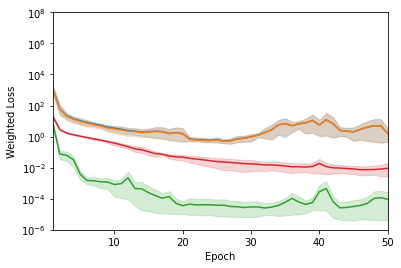

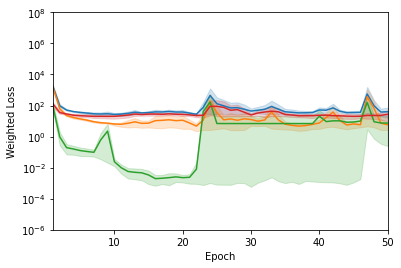

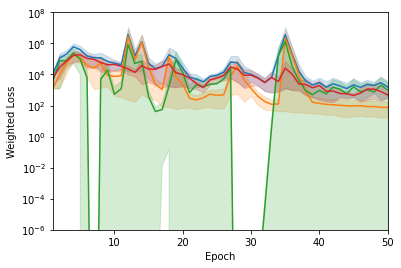

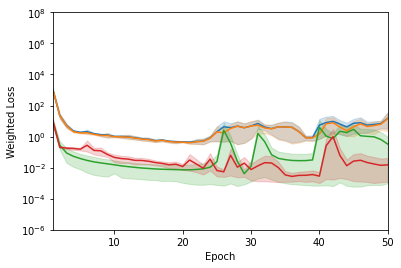

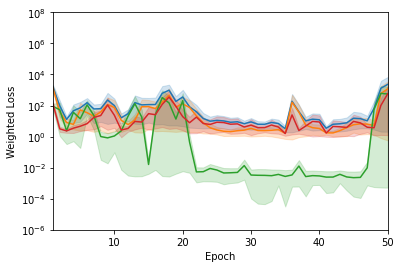

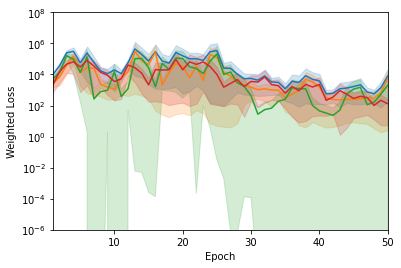

In [103]:
for distractor, lambda_val in itertools.product(distractors, lambdas):
    df_filtered = df[df.distractor == distractor].copy(deep = True)
    df_filtered = df_filtered[df_filtered["lambda"] == lambda_val].copy(deep = True)
    data = df_filtered[df_filtered.metric.isin(["epoch_loss", "epoch_target_output_loss", "epoch_attr_0_output_loss","epoch_attr_1_output_loss"])]
    data = data.replace("epoch_loss", "Total")
    data = data.replace("epoch_target_output_loss", "Target")
    data = data.replace("epoch_attr_0_output_loss", "Color")
    data = data.replace("epoch_attr_1_output_loss", "Type")
    ax = sns.lineplot(data = data, x="step", y="weighted_loss", hue = "metric")
    ax.set_ylabel("Weighted Loss")
    ax.set_xlabel("Epoch")
    ax.legend_.remove()
    ax.set_xlim([1, 50])
    ax.set_yscale('log')
    ax.set_ylim([1e-6, 1e8])
    plt.savefig("C:/repos/twrds_unbiased_anns/figures/results/grad/losses/weighted_loss_plot_{}_{}_{}.png".format(distractor, lambda_val, target_loss), dpi = 200, bbox_inches = 'tight')
    plt.show()

## Accuracy Plots

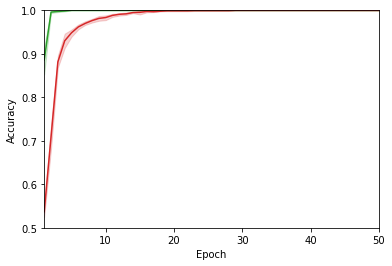

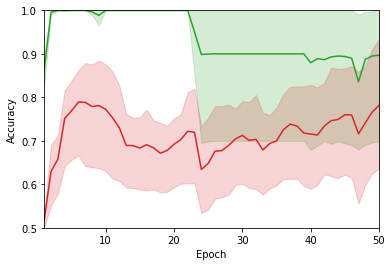

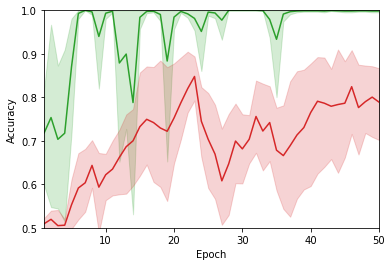

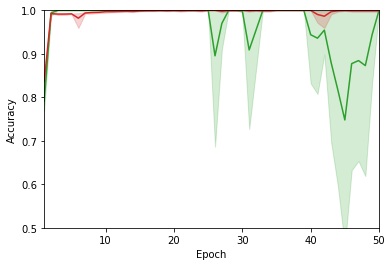

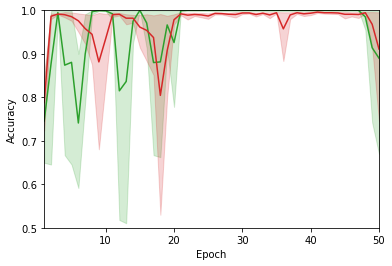

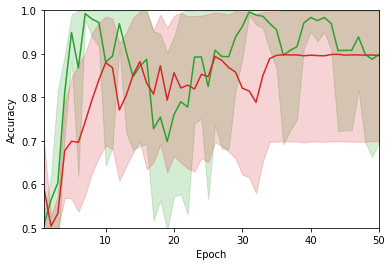

In [7]:
current_palette = sns.color_palette()
sns.set_palette(current_palette[2:])

for distractor, lambda_val in itertools.product(distractors, lambdas):
    df_filtered = df[df.distractor == distractor].copy(deep = True)
    df_filtered = df_filtered[df_filtered["lambda"] == lambda_val].copy(deep = True)
    data = df_filtered[df_filtered.metric.isin(["epoch_attr_0_output_accuracy","epoch_attr_1_output_accuracy"])]
    data = data.replace("epoch_attr_0_output_accuracy", "Color")
    data = data.replace("epoch_attr_1_output_accuracy", "Type")
    ax = sns.lineplot(data = data, x="step", y="value", hue = "metric")
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epoch")
    ax.legend_.remove()
    ax.set_xlim([1, 50])
    ax.set_ylim([0.5, 1])
    plt.savefig("C:/repos/twrds_unbiased_anns/figures/results/grad/losses/accuracy_plot_{}_{}_{}.png".format(distractor, lambda_val, target_loss), dpi = 200, bbox_inches = 'tight')
    plt.show()
    
sns.set_palette(current_palette)

# Experiment 2
## Data Loading

In [20]:
df = load_run_data(run = "grad_losses", date = "26-05-2021", results_path = results_path)

df_over = df[df.group == "over"]
df_under = df[df.group == "under"]

df

,Unnamed: 0,run,date,model,attr_loss_weight,loss,category,m_diff,stddev,minority_share,repeat,shape_color,shape_type,actual,prediction,group,prediction_diff,rmse
0,0,grad_losses,2021-05-26 10:31:25.610,GRAD,1000,mse,color,50,3,50,1,white,square,115,0.006560,over,-114.993440,114.993440
1,1,grad_losses,2021-05-26 10:31:25.610,GRAD,1000,mse,color,50,3,50,1,white,square,127,0.006560,over,-126.993440,126.993440
2,2,grad_losses,2021-05-26 10:31:25.610,GRAD,1000,mse,color,50,3,50,1,white,square,113,0.006560,over,-112.993440,112.993440
3,3,grad_losses,2021-05-26 10:31:25.610,GRAD,1000,mse,color,50,3,50,1,white,square,107,0.006560,over,-106.993440,106.993440
4,4,grad_losses,2021-05-26 10:31:25.610,GRAD,1000,mse,color,50,3,50,1,white,square,92,0.006560,over,-91.993440,91.993440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,grad_losses,2021-05-26 10:31:25.610,GRAD,10,mse,shape,50,3,50,5,colorful,circle,77,59.709942,under,-17.290058,17.290058
14996,14996,grad_losses,2021-05-26 10:31:25.610,GRAD,10,mse,shape,50,3,50,5,colorful,circle,84,74.177185,under,-9.822815,9.822815
14997,14997,grad_losses,2021-05-26 10:31:25.610,GRAD,10,mse,shape,50,3,50,5,colorful,circle,102,82.365868,under,-19.634132,19.634132
14998,14998,grad_losses,2021-05-26 10:31:25.610,GRAD,10,mse,shape,50,3,50,5,colorful,circle,108,104.632957,under,-3.367043,3.367043


In [21]:
results = []

# Group data
predictors = ["category", "attr_loss_weight"]
grouped = df.groupby(predictors)

# Go through groups
for category, attr_loss_weight in grouped.groups.keys():
    
    # Get data
    data = grouped.get_group((category, attr_loss_weight))
    
    # Overall data
    avg_prediction, avg_rmse = get_results(data)
    
    # White shapes
    white_shapes = data[data.group == "over"]
    avg_prediction_w, avg_rmse_w = get_results(white_shapes)
    
    # Red shapes
    red_shapes = data[data.group == "under"]
    avg_prediction_r, avg_rmse_r = get_results(red_shapes)
    
    # Perform KS-Test
    ks_stat, ks_p = ks_2samp(white_shapes.prediction, red_shapes.prediction)
        
    # Store data
    results.append(
        {
            "category": category,
            "attr_loss_weight": attr_loss_weight,            
            "count": data.shape[0],
            "avg_prediction_w": avg_prediction_w,
            "avg_prediction_r": avg_prediction_r,
            "avg_rmse_w": avg_rmse_w,
            "avg_rmse_r": avg_rmse_r,    
            "ks_stat": ks_stat,
            "ks_p": ks_p,
            "prediction_diff": avg_prediction_w - avg_prediction_r,
            "rmse_diff": avg_rmse_w - avg_rmse_r
            
        }
    )
    
# Make dataframe of results
df_results = pd.DataFrame(results)
df_results

,category,attr_loss_weight,count,avg_prediction_w,avg_prediction_r,avg_rmse_w,avg_rmse_r,ks_stat,ks_p,prediction_diff,rmse_diff
0,color,10,2500,75.351691,43.111796,34.841754,58.334648,0.5856,6.095025e-199,32.239895,-23.492894
1,color,100,2500,137.705915,272.823060,216.131453,404.010600,0.2960,1.088662e-48,-135.117144,-187.879147
2,color,1000,2500,-1310.298074,-854.913211,1927.126809,1114.057963,0.1608,1.617510e-14,-455.384863,813.068846
3,shape,10,2500,201.024749,212.088026,125.005796,142.162622,0.1072,1.129749e-06,-11.063277,-17.156826
4,shape,100,2500,118.024858,88.807831,381.160605,370.175094,0.0688,5.375209e-03,29.217027,10.985511
5,shape,1000,2500,21.024066,-81.840673,393.495629,343.478620,0.1552,1.503941e-13,102.864740,50.017009


In [18]:
print_to_latex(df_results)


% Results of 1st experiment
\renewcommand{\arraystretch}{1}
\begin{table}[h!]
\centering
\renewcommand*\TPTnoteLabel[1]{\parbox[b]{3em}{\hfill#1\,}}
\begin{threeparttable}
\begin{tabular*}{\textwidth}{SSS @{\extracolsep{\fill}} SSSSSS[table-format=1.2e-2, table-align-text-post = false, table-space-text-post = \tnote{ **** }] @{\extracolsep{\fill}}}
\toprule
&&& \multicolumn{2}{c}{White Shapes} & \multicolumn{2}{c}{Red Shapes} & \multicolumn{2}{c}{KS Test} \\
\cmidrule(l{2pt}r{2pt}){4-5}
\cmidrule(l{2pt}r{2pt}){6-7}
\cmidrule(l{2pt}r{2pt}){8-9}
{$\sigma$} & {$\mathrm{\%}_{\mathrm{red}}$} & {$\mu$} & {Pred.} & {RMSE} & {Pred.} & {RMSE} & {$d_{\mathrm{n}}$} & {$p$-value} \\ \midrule

color & 10 & 75.35 & 34.84 & 43.11 & 58.33 & 0.59& 6.10e-199\tnote{ ****} \\
color & 100 & 137.71 & 216.13 & 272.82 & 404.01 & 0.30& 1.09e-48\tnote{ ****} \\
color & 1000 & -1310.30 & 1927.13 & -854.91 & 1114.06 & 0.16& 1.62e-14\tnote{ ****} \\
shape & 10 & 201.02 & 125.01 & 212.09 & 142.16 & 0.11& 1.13e-06\

## Loss Plots

In [10]:
# Path to log
base_path = "C:/repos/"
sys.path.append(base_path)
runs_path = base_path + "twrds_unbiased_anns/runs/"
run_dir = runs_path + "grad_losses"
log_base_dir = run_dir + "/logs/"

# Load logs
df = many_logs2pandas(getListOfFiles(log_base_dir))
# Add one to step
df["step"] = df["step"] + 1
df

,metric,value,step,distractor,lambda
0,epoch_loss,3.572866e+04,1.0,color,1000
1,epoch_loss,3.124576e+05,2.0,color,1000
2,epoch_loss,6.123622e+05,3.0,color,1000
3,epoch_loss,9.880306e+05,4.0,color,1000
4,epoch_loss,2.115204e+06,5.0,color,1000
...,...,...,...,...,...
10495,epoch_attr_1_output_accuracy,1.000000e+00,46.0,shape,10
10496,epoch_attr_1_output_accuracy,9.975000e-01,47.0,shape,10
10497,epoch_attr_1_output_accuracy,9.950000e-01,48.0,shape,10
10498,epoch_attr_1_output_accuracy,1.000000e+00,49.0,shape,10


In [11]:
# Params for plotting
distractors = ["color", "shape"]
lambdas = [10, 100, 1000]
target_loss = 0.001

# Calculate weighted losses
conditions = [
    (df["metric"] == "epoch_loss"),
    (df["metric"] == "epoch_target_output_loss"),
    (df["metric"] == "epoch_attr_0_output_loss"),
    (df["metric"] == "epoch_attr_1_output_loss")
]

df["loss_base_weight"] = np.select(conditions, [1, target_loss, 0, 0])
df["loss_lambda_weight"] = np.select(conditions, [0, 0, 0.5, 0.5])

df["loss_weight"] = df["loss_base_weight"] + df["loss_lambda_weight"] * df["lambda"]
df["weighted_loss"] = df["loss_weight"] * df["value"]
df

,metric,value,step,distractor,lambda,loss_base_weight,loss_lambda_weight,loss_weight,weighted_loss
0,epoch_loss,3.572866e+04,1.0,color,1000,1.0,0.0,1.0,3.572866e+04
1,epoch_loss,3.124576e+05,2.0,color,1000,1.0,0.0,1.0,3.124576e+05
2,epoch_loss,6.123622e+05,3.0,color,1000,1.0,0.0,1.0,6.123622e+05
3,epoch_loss,9.880306e+05,4.0,color,1000,1.0,0.0,1.0,9.880306e+05
4,epoch_loss,2.115204e+06,5.0,color,1000,1.0,0.0,1.0,2.115204e+06
...,...,...,...,...,...,...,...,...,...
10495,epoch_attr_1_output_accuracy,1.000000e+00,46.0,shape,10,0.0,0.0,0.0,0.000000e+00
10496,epoch_attr_1_output_accuracy,9.975000e-01,47.0,shape,10,0.0,0.0,0.0,0.000000e+00
10497,epoch_attr_1_output_accuracy,9.950000e-01,48.0,shape,10,0.0,0.0,0.0,0.000000e+00
10498,epoch_attr_1_output_accuracy,1.000000e+00,49.0,shape,10,0.0,0.0,0.0,0.000000e+00


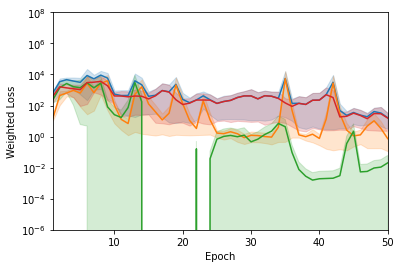

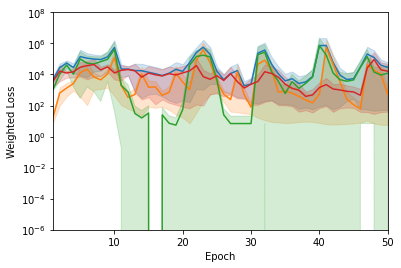

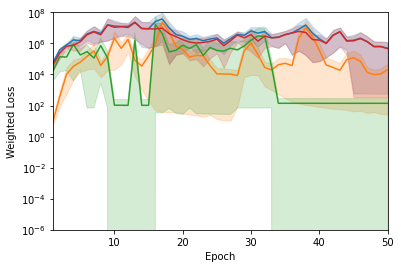

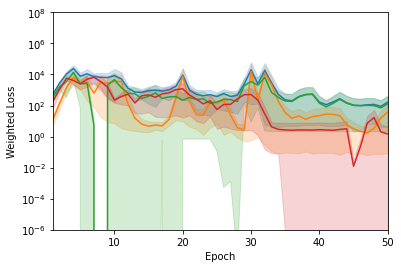

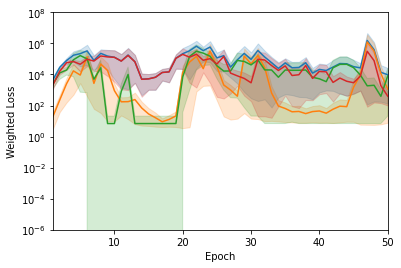

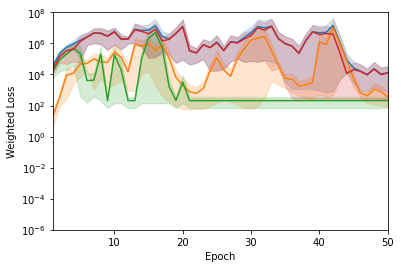

In [12]:
for distractor, lambda_val in itertools.product(distractors, lambdas):
    df_filtered = df[df.distractor == distractor].copy(deep = True)
    df_filtered = df_filtered[df_filtered["lambda"] == lambda_val].copy(deep = True)
    data = df_filtered[df_filtered.metric.isin(["epoch_loss", "epoch_target_output_loss", "epoch_attr_0_output_loss","epoch_attr_1_output_loss"])]
    data = data.replace("epoch_loss", "Total")
    data = data.replace("epoch_target_output_loss", "Target")
    data = data.replace("epoch_attr_0_output_loss", "Color")
    data = data.replace("epoch_attr_1_output_loss", "Type")
    ax = sns.lineplot(data = data, x="step", y="weighted_loss", hue = "metric")
    ax.set_ylabel("Weighted Loss")
    ax.set_xlabel("Epoch")
    ax.legend_.remove()
    ax.set_xlim([1, 50])
    ax.set_yscale('log')
    ax.set_ylim([1e-6, 1e8])
    plt.savefig("C:/repos/twrds_unbiased_anns/figures/results/grad/losses/weighted_loss_plot_{}_{}_{}.png".format(distractor, lambda_val, target_loss), dpi = 200, bbox_inches = 'tight')
    plt.show()

## Accuracy Plot

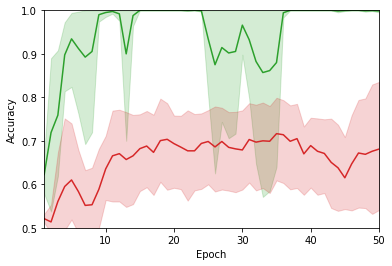

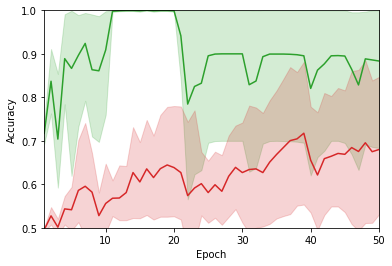

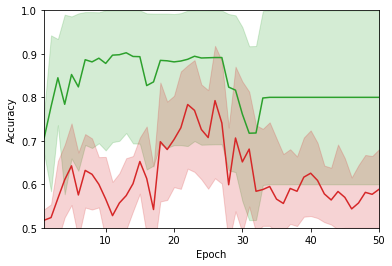

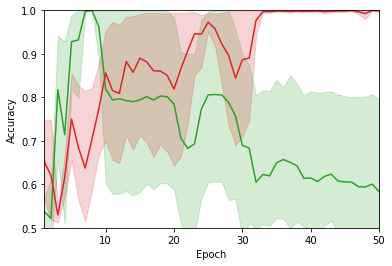

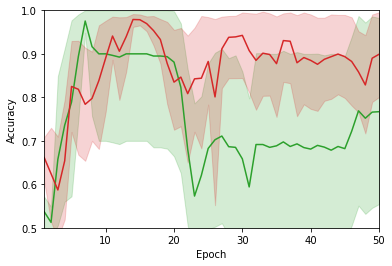

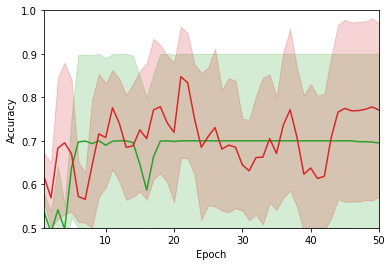

In [13]:
current_palette = sns.color_palette()
sns.set_palette(current_palette[2:])

for distractor, lambda_val in itertools.product(distractors, lambdas):
    df_filtered = df[df.distractor == distractor].copy(deep = True)
    df_filtered = df_filtered[df_filtered["lambda"] == lambda_val].copy(deep = True)
    data = df_filtered[df_filtered.metric.isin(["epoch_attr_0_output_accuracy","epoch_attr_1_output_accuracy"])]
    data = data.replace("epoch_attr_0_output_accuracy", "Color")
    data = data.replace("epoch_attr_1_output_accuracy", "Type")
    ax = sns.lineplot(data = data, x="step", y="value", hue = "metric")
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epoch")
    ax.legend_.remove()
    ax.set_xlim([1, 50])
    ax.set_ylim([0.5, 1])
    plt.savefig("C:/repos/twrds_unbiased_anns/figures/results/grad/losses/accuracy_plot_{}_{}_{}.png".format(distractor, lambda_val, target_loss), dpi = 200, bbox_inches = 'tight')
    plt.show()
    
sns.set_palette(current_palette)

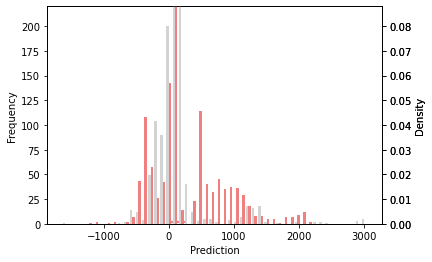

In [25]:
df_filtered = df[df.category == "color"].copy(deep = True)
df_filtered = df_filtered[df_filtered["attr_loss_weight"] == 100].copy(deep = True)
colors = ["lightgrey", "lightcoral"]

# Get predictions
data = [df_filtered[df_filtered.group == "over"].prediction, df_filtered[df_filtered.group == "under"].prediction]     
# Fit normal distribution
mu_1, std_1 = norm.fit(data[0])
mu_2, std_2 = norm.fit(data[1])

# Create plot
fig = plt.plot(figsize=(10,3.75))
ax = plt.gca()      
# Plot histogram
ax.hist(data, color = colors, bins = 50)
#ax.set_xlim(0,150)
#ax.set_ylim(0,150)
ax.set_ylabel('Frequency')  
ax.set_xlabel('Prediction')



# Plot distribution curve
for cat_data, color in zip(data, colors):
    # Fit a normal distribution to the data
    mu, std = norm.fit(cat_data)
    # Calculate PDF
    xmin, xmax = 0, 250
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    # Plot PDF
    ax2 = ax.twinx()
    ax2.plot(x, p, color = color, linewidth = 2)
    ax.set_ylim([0,220])
    # Calculate ylim of second axis based on first axis      
    ylim_max_1 = ax.get_ylim()[1]
    ylim_max_2 = ylim_max_1 / (data[0].size + data[1].size)   
    ax2.set_ylim([0, ylim_max_2])  
    ax2.set_ylabel('Density')    
    # Fix plot display order
    ax.set_zorder(ax2.get_zorder()+1)
    ax.patch.set_visible(False)

plt.savefig(figure_path + "hist_color_100_1", dpi = 200, bbox_inches = 'tight')
plt.show()


# Experiment 3

In [15]:
df = load_run_data(run = "grad_single", date = "27-05-2021", results_path = results_path)

df_over = df[df.group == "over"]
df_under = df[df.group == "under"]

df

,Unnamed: 0,run,date,model,attr_loss_weight,loss,category,m_diff,stddev,minority_share,repeat,shape_color,shape_type,actual,prediction,group,prediction_diff,rmse
0,0,grad_single,2021-05-27 22:45:24.551,GRAD,1000.0,mse,color,50,3,50,1,white,square,115,121.358887,over,6.358887,6.358887
1,1,grad_single,2021-05-27 22:45:24.551,GRAD,1000.0,mse,color,50,3,50,1,white,square,127,131.427734,over,4.427734,4.427734
2,2,grad_single,2021-05-27 22:45:24.551,GRAD,1000.0,mse,color,50,3,50,1,white,square,113,119.659668,over,6.659668,6.659668
3,3,grad_single,2021-05-27 22:45:24.551,GRAD,1000.0,mse,color,50,3,50,1,white,square,107,118.966309,over,11.966309,11.966309
4,4,grad_single,2021-05-27 22:45:24.551,GRAD,1000.0,mse,color,50,3,50,1,white,square,92,93.562012,over,1.562012,1.562012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12495,12495,grad_single,2021-05-27 22:45:24.551,GRAD,0.1,mse,color,50,3,50,5,colorful,circle,77,102.930923,under,25.930923,25.930923
12496,12496,grad_single,2021-05-27 22:45:24.551,GRAD,0.1,mse,color,50,3,50,5,colorful,circle,84,130.969833,under,46.969833,46.969833
12497,12497,grad_single,2021-05-27 22:45:24.551,GRAD,0.1,mse,color,50,3,50,5,colorful,circle,102,216.645706,under,114.645706,114.645706
12498,12498,grad_single,2021-05-27 22:45:24.551,GRAD,0.1,mse,color,50,3,50,5,colorful,circle,108,248.440674,under,140.440674,140.440674


In [19]:
attr_loss_weight = 10,
repeat = 2

In [23]:
df.loc[(df.attr_loss_weight == attr_loss_weight) & (df.repeat == repeat)]

,Unnamed: 0,run,date,model,attr_loss_weight,loss,category,m_diff,stddev,minority_share,repeat,shape_color,shape_type,actual,prediction,group,prediction_diff,rmse
5500,5500,grad_single,2021-05-27 22:45:24.551,GRAD,10.0,mse,color,50,3,50,2,white,square,115,111.307030,over,-3.692970,3.692970
5501,5501,grad_single,2021-05-27 22:45:24.551,GRAD,10.0,mse,color,50,3,50,2,white,square,127,90.420067,over,-36.579933,36.579933
5502,5502,grad_single,2021-05-27 22:45:24.551,GRAD,10.0,mse,color,50,3,50,2,white,square,113,111.627098,over,-1.372902,1.372902
5503,5503,grad_single,2021-05-27 22:45:24.551,GRAD,10.0,mse,color,50,3,50,2,white,square,107,106.613426,over,-0.386574,0.386574
5504,5504,grad_single,2021-05-27 22:45:24.551,GRAD,10.0,mse,color,50,3,50,2,white,square,92,83.556664,over,-8.443336,8.443336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,5995,grad_single,2021-05-27 22:45:24.551,GRAD,10.0,mse,color,50,3,50,2,colorful,circle,77,37.500755,under,-39.499245,39.499245
5996,5996,grad_single,2021-05-27 22:45:24.551,GRAD,10.0,mse,color,50,3,50,2,colorful,circle,84,36.925743,under,-47.074257,47.074257
5997,5997,grad_single,2021-05-27 22:45:24.551,GRAD,10.0,mse,color,50,3,50,2,colorful,circle,102,33.361839,under,-68.638161,68.638161
5998,5998,grad_single,2021-05-27 22:45:24.551,GRAD,10.0,mse,color,50,3,50,2,colorful,circle,108,32.398949,under,-75.601051,75.601051


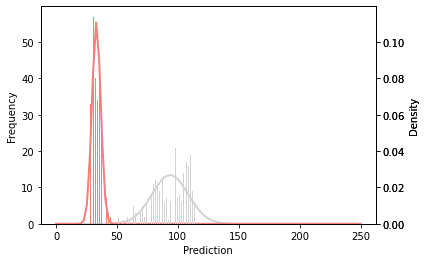

In [25]:
df_filtered = df.loc[(df.attr_loss_weight == attr_loss_weight) & (df.repeat == repeat)]
colors = ["lightgrey", "lightcoral"]

# Get predictions
data = [df_filtered[df_filtered.group == "over"].prediction, df_filtered[df_filtered.group == "under"].prediction]     
# Fit normal distribution
mu_1, std_1 = norm.fit(data[0])
mu_2, std_2 = norm.fit(data[1])

# Create plot
fig = plt.plot(figsize=(10,3.75))
ax = plt.gca()      
# Plot histogram
ax.hist(data, color = colors, bins = 50)
#ax.set_xlim(0,150)
#ax.set_ylim(0,150)
ax.set_ylabel('Frequency')  
ax.set_xlabel('Prediction')



# Plot distribution curve
for cat_data, color in zip(data, colors):
    # Fit a normal distribution to the data
    mu, std = norm.fit(cat_data)
    # Calculate PDF
    xmin, xmax = 0, 250
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    # Plot PDF
    ax2 = ax.twinx()
    ax2.plot(x, p, color = color, linewidth = 2)
    #ax.set_ylim([0,220])
    # Calculate ylim of second axis based on first axis      
    ylim_max_1 = ax.get_ylim()[1]
    ylim_max_2 = ylim_max_1 / (data[0].size + data[1].size)   
    ax2.set_ylim([0, ylim_max_2])  
    ax2.set_ylabel('Density')    
    # Fix plot display order
    ax.set_zorder(ax2.get_zorder()+1)
    ax.patch.set_visible(False)

#plt.savefig(figure_path + "hist_color_100_1", dpi = 200, bbox_inches = 'tight')
plt.show()


## Loss Plots

In [27]:
# Path to log
base_path = "C:/repos/"
sys.path.append(base_path)
runs_path = base_path + "twrds_unbiased_anns/runs/"
run_dir = runs_path + "grad_single"
log_base_dir = run_dir + "/logs/"

# Load logs
df = many_logs2pandas(getListOfFiles(log_base_dir))
# Add one to step
df["step"] = df["step"] + 1
df

,metric,value,step,distractor,lambda
0,epoch_loss,2.084028,1.0,color,0.1
1,epoch_loss,0.055490,2.0,color,0.1
2,epoch_loss,0.019114,3.0,color,0.1
3,epoch_loss,0.014674,4.0,color,0.1
4,epoch_loss,0.011809,5.0,color,0.1
...,...,...,...,...,...
6245,epoch_attr_0_output_accuracy,1.000000,46.0,color,1.0
6246,epoch_attr_0_output_accuracy,1.000000,47.0,color,1.0
6247,epoch_attr_0_output_accuracy,1.000000,48.0,color,1.0
6248,epoch_attr_0_output_accuracy,1.000000,49.0,color,1.0


In [28]:
# Params for plotting
distractors = ["color"]
lambdas = [0.1, 1, 10, 100, 1000]
target_loss = 0.001

# Calculate weighted losses
conditions = [
    (df["metric"] == "epoch_loss"),
    (df["metric"] == "epoch_target_output_loss"),
    (df["metric"] == "epoch_attr_0_output_loss")
]

df["loss_base_weight"] = np.select(conditions, [1, target_loss, 0])
df["loss_lambda_weight"] = np.select(conditions, [0, 0, 0.5])

df["loss_weight"] = df["loss_base_weight"] + df["loss_lambda_weight"] * df["lambda"]
df["weighted_loss"] = df["loss_weight"] * df["value"]
df

,metric,value,step,distractor,lambda,loss_base_weight,loss_lambda_weight,loss_weight,weighted_loss
0,epoch_loss,2.084028,1.0,color,0.1,1.0,0.0,1.0,2.084028
1,epoch_loss,0.055490,2.0,color,0.1,1.0,0.0,1.0,0.055490
2,epoch_loss,0.019114,3.0,color,0.1,1.0,0.0,1.0,0.019114
3,epoch_loss,0.014674,4.0,color,0.1,1.0,0.0,1.0,0.014674
4,epoch_loss,0.011809,5.0,color,0.1,1.0,0.0,1.0,0.011809
...,...,...,...,...,...,...,...,...,...
6245,epoch_attr_0_output_accuracy,1.000000,46.0,color,1.0,0.0,0.0,0.0,0.000000
6246,epoch_attr_0_output_accuracy,1.000000,47.0,color,1.0,0.0,0.0,0.0,0.000000
6247,epoch_attr_0_output_accuracy,1.000000,48.0,color,1.0,0.0,0.0,0.0,0.000000
6248,epoch_attr_0_output_accuracy,1.000000,49.0,color,1.0,0.0,0.0,0.0,0.000000


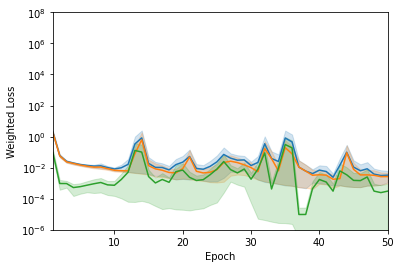

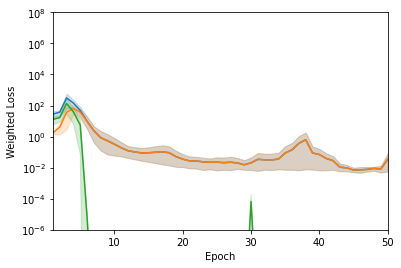

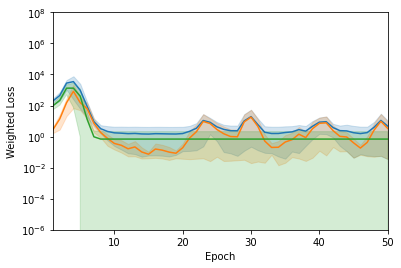

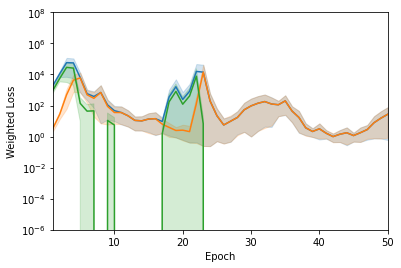

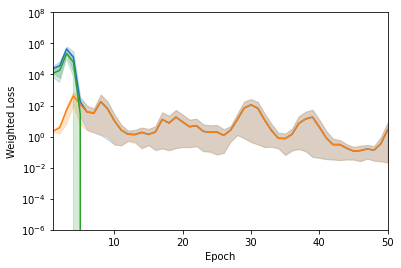

In [13]:
for distractor, lambda_val in itertools.product(distractors, lambdas):
    df_filtered = df[df.distractor == distractor].copy(deep = True)
    df_filtered = df_filtered[df_filtered["lambda"] == lambda_val].copy(deep = True)
    data = df_filtered[df_filtered.metric.isin(["epoch_loss", "epoch_target_output_loss", "epoch_attr_0_output_loss","epoch_attr_1_output_loss"])]
    data = data.replace("epoch_loss", "Total")
    data = data.replace("epoch_target_output_loss", "Target")
    data = data.replace("epoch_attr_0_output_loss", "Color")
    data = data.replace("epoch_attr_1_output_loss", "Type")
    ax = sns.lineplot(data = data, x="step", y="weighted_loss", hue = "metric")
    ax.set_ylabel("Weighted Loss")
    ax.set_xlabel("Epoch")
    ax.legend_.remove()
    ax.set_xlim([1, 50])
    ax.set_yscale('log')
    ax.set_ylim([1e-6, 1e8])
    #plt.savefig("C:/repos/twrds_unbiased_anns/figures/results/grad/losses/weighted_loss_plot_{}_{}_{}.png".format(distractor, lambda_val, target_loss), dpi = 200, bbox_inches = 'tight')
    plt.show()

## Accuracy Plots

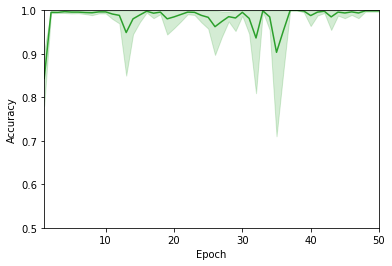

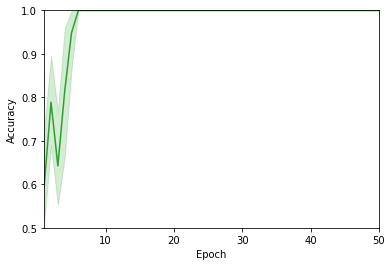

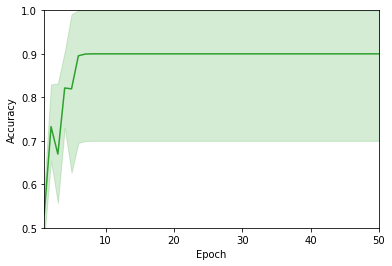

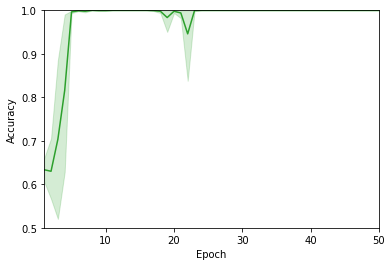

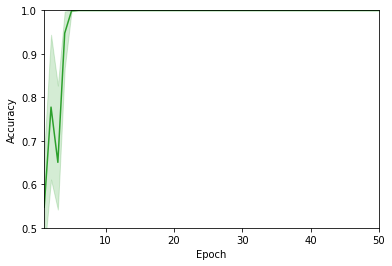

In [14]:
current_palette = sns.color_palette()
sns.set_palette(current_palette[2:])

for distractor, lambda_val in itertools.product(distractors, lambdas):
    df_filtered = df[df.distractor == distractor].copy(deep = True)
    df_filtered = df_filtered[df_filtered["lambda"] == lambda_val].copy(deep = True)
    data = df_filtered[df_filtered.metric.isin(["epoch_attr_0_output_accuracy","epoch_attr_1_output_accuracy"])]
    data = data.replace("epoch_attr_0_output_accuracy", "Color")
    data = data.replace("epoch_attr_1_output_accuracy", "Type")
    ax = sns.lineplot(data = data, x="step", y="value", hue = "metric")
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epoch")
    ax.legend_.remove()
    ax.set_xlim([1, 50])
    ax.set_ylim([0.5, 1])
    #plt.savefig("C:/repos/twrds_unbiased_anns/figures/results/grad/losses/accuracy_plot_{}_{}_{}.png".format(distractor, lambda_val, target_loss), dpi = 200, bbox_inches = 'tight')
    plt.show()
    
sns.set_palette(current_palette)

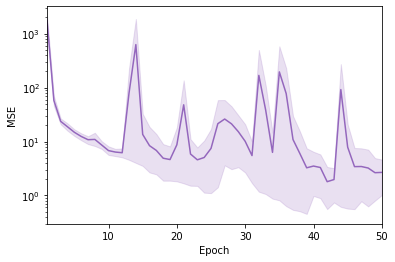

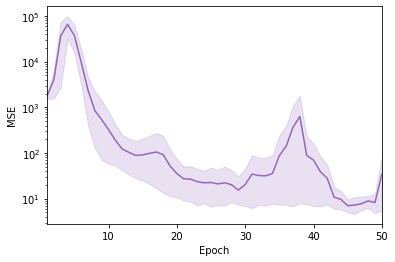

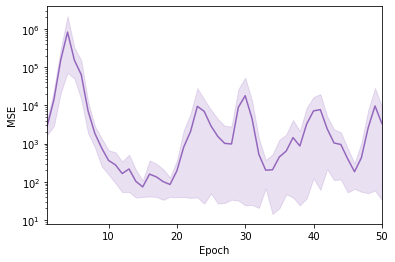

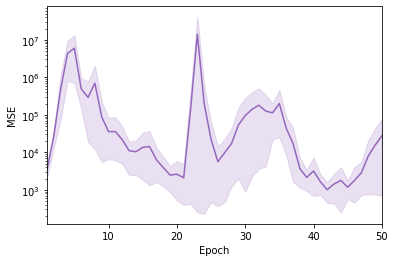

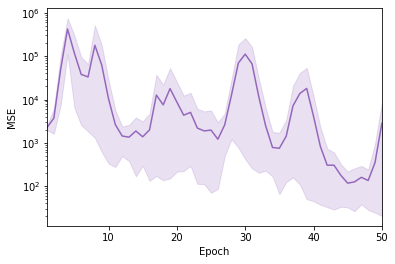

In [30]:
current_palette = sns.color_palette()
sns.set_palette(current_palette[2:])

for distractor, lambda_val in itertools.product(distractors, lambdas):
    df_filtered = df[df.distractor == distractor].copy(deep = True)
    df_filtered = df_filtered[df_filtered["lambda"] == lambda_val].copy(deep = True)
    data = df_filtered[df_filtered.metric.isin(["epoch_target_output_mean_squared_error"])]
    data = data.replace("epoch_target_output_mean_squared_error", "MSE")
    ax = sns.lineplot(data = data, x="step", y="value", hue = "metric")
    ax.set_ylabel("MSE")
    ax.set_xlabel("Epoch")
    ax.legend_.remove()
    ax.set_xlim([1, 50])
    ax.set_yscale('log')
    #ax.set_ylim([0.5, 1])
    #plt.savefig("C:/repos/twrds_unbiased_anns/figures/results/grad/losses/accuracy_plot_{}_{}_{}.png".format(distractor, lambda_val, target_loss), dpi = 200, bbox_inches = 'tight')
    plt.show()
    
sns.set_palette(current_palette)

## OLS Analysis

In [12]:
predictors = ["stddev", "mean_red", "minority_share"]

# Initialize all combinations for OLS regression to test for interactions
ols_predictors = ""
for predictor in predictors:
    ols_predictors = ols_predictors + predictor + " + " 
ols_predictors = ols_predictors + "stddev * mean_red * minority_share"

# Define targets
targets = ["prediction", "rmse"]

# Create empty dataframe for OLS results
ols_df = pd.DataFrame()

for target in targets:
    model = ols('{} ~ {}'.format(target, ols_predictors), df_under).fit()
    ols_df["{}_coef".format(target)] = model.params
    ols_df["{}_t".format(target)] = model.tvalues
    ols_df["{}_p".format(target)] = model.pvalues

ols_df

,prediction_coef,prediction_t,prediction_p,rmse_coef,rmse_t,rmse_p
Intercept,27.825829,66.724490,0.000000e+00,71.068865,352.919054,0.000000e+00
stddev,1.530583,61.029742,0.000000e+00,-1.492156,-123.213284,0.000000e+00
mean_red,0.726790,143.934538,0.000000e+00,-0.700283,-287.202505,0.000000e+00
minority_share,0.398082,25.349263,1.449468e-141,-0.406180,-53.563622,0.000000e+00
stddev:mean_red,-0.015331,-50.486253,0.000000e+00,0.014871,101.418190,0.000000e+00
stddev:minority_share,0.019950,21.124312,5.936678e-99,-0.018621,-40.832145,0.000000e+00
mean_red:minority_share,-0.003289,-17.295665,5.604836e-67,0.003421,37.261575,5.827577e-303
stddev:mean_red:minority_share,-0.000226,-19.727094,1.494525e-86,0.000207,37.526181,3.103090e-307


In [13]:
# Print table to LaTeX
latex_df = ols_df.reset_index()

# Check number of interactions
latex_df["interaction_level"] = latex_df["index"].str.count(":")

# Format interaction column for latex export
latex_df["index"] = latex_df["index"].str.replace(":", " $\\times$ ", regex = False)
latex_df["index"] = latex_df["index"].str.replace("stddev", "$\sigma$", regex = False)
latex_df["index"] = latex_df["index"].str.replace("minority_share", "$\%_\mathrm{red}$", regex = False)
latex_df["index"] = latex_df["index"].str.replace("m_red", "$\mu$", regex = False)

# Format coefficients
latex_df["prediction_coef"] = latex_df["prediction_coef"].apply(lambda x: convert_val_to_str(x))
latex_df["rmse_coef"] = latex_df["rmse_coef"].apply(lambda x: convert_val_to_str(x))

# Format t values
latex_df["prediction_t"] = latex_df["prediction_t"].apply(lambda x: convert_val_to_str(x))
latex_df["rmse_t"] = latex_df["rmse_t"].apply(lambda x: convert_val_to_str(x))

# Get significance
latex_df["prediction_sign"] = latex_df["prediction_p"].apply(lambda p: get_significance_string_latex(p))
latex_df["rmse_sign"] = latex_df["rmse_p"].apply(lambda p: get_significance_string_latex(p))

# Format p values
latex_df["prediction_p"] = latex_df["prediction_p"].apply(lambda p: convert_p_val_to_str(p))
latex_df["rmse_p"] = latex_df["rmse_p"].apply(lambda p: convert_p_val_to_str(p))

# Sort by number of interactions
latex_df.sort_values("interaction_level", inplace = True)

for index, row in latex_df.iterrows():
    print("{} & {} {} & {} {} \\\\".format(row["index"], row["prediction_coef"], row["prediction_sign"], row["rmse_coef"], row["rmse_sign"]))

Intercept & 27.8258 \tnote{****} & 71.0689 \tnote{****} \\
$\sigma$ & 1.5306 \tnote{****} & -1.4922 \tnote{****} \\
mean_red & 0.7268 \tnote{****} & -0.7003 \tnote{****} \\
$\%_\mathrm{red}$ & 0.3981 \tnote{****} & -0.4062 \tnote{****} \\
$\sigma$ $\times$ mean_red & -0.0153 \tnote{****} & 0.0149 \tnote{****} \\
$\sigma$ $\times$ $\%_\mathrm{red}$ & 0.0199 \tnote{****} & -0.0186 \tnote{****} \\
mean_red $\times$ $\%_\mathrm{red}$ & -0.0033 \tnote{****} & 0.0034 \tnote{****} \\
$\sigma$ $\times$ mean_red $\times$ $\%_\mathrm{red}$ & -0.0002 \tnote{****} & 0.0002 \tnote{****} \\


## Individual Plots

In [11]:
def plot_means(df, predictor, target, color, ax):    
    # Get 95% confidence intervals of means
    stats = df.groupby([predictor])[target].agg(['mean', 'count', 'std'])
    ci95_hi = []
    ci95_lo = []
    for i in stats.index:
      m, c, s = stats.loc[i]
      ci95_hi.append(m + 1.95*s/np.sqrt(c))
      ci95_lo.append(m - 1.95*s/np.sqrt(c))
    stats['ci95_hi'] = ci95_hi
    stats['ci95_lo'] = ci95_lo
    stats['grp'] = stats.index
    # Plot confidence intervals
    for grp in stats.index:
        ax.vlines(x=grp, ymin=stats.loc[grp]['ci95_lo'], ymax=stats.loc[grp]['ci95_hi'], color = color)
    # Plot means
    ax.scatter(x=stats['grp'], y=stats['mean'], s = 10, color = color)
    
def plot_linear_ols(df, predictor, target, color, ax, line_x, label = None):
    # Fit OLS to each data group
    model = ols('{} ~ {}'.format(target, predictor), df).fit()
    # Plot OLS lines
    p = model.params
    line_y = p.Intercept + p[1] * line_x
    if label:
        ax.plot(line_x, line_y, color = color, label = label)
    else:
        ax.plot(line_x, line_y, color = color)
    
def plot_log_ols(df, predictor, target, color, ax, line_x, label = None):
    # Fit OLS to each data group
    model = ols('{} ~ {}'.format(target, "log_" + predictor), df).fit()
    # Plot OLS lines
    p = model.params
    line_y = p.Intercept + p[1] * np.log(line_x)
    if label:
        ax.plot(line_x, line_y, color = color, label = label)
    else:
        ax.plot(line_x, line_y, color = color)
        
def plot_reciprocal_ols(df, predictor, target, color, ax, line_x, label = None):
    df["transformed_" + predictor] = 1 / df[predictor]
    # Fit OLS to each data group
    model = ols('{} ~ {}'.format(target, "transformed_" + predictor), df).fit()
    # Plot OLS lines
    p = model.params
    line_y = p.Intercept + p[1] * (1 / line_x)
    if label:
        ax.plot(line_x, line_y, color = color, label = label)
    else:
        ax.plot(line_x, line_y, color = color)
        
def plot_square_reciprocal_ols(df, predictor, target, color, ax, line_x, label = None):
    df["transformed_" + predictor] = 1 / np.square(df[predictor])
    # Fit OLS to each data group
    model = ols('{} ~ {}'.format(target, "transformed_" + predictor), df).fit()
    # Plot OLS lines
    p = model.params
    line_y = p.Intercept + p[1] * (1 / np.square(line_x))
    if label:
        ax.plot(line_x, line_y, color = color, label = label)
    else:
        ax.plot(line_x, line_y, color = color)

PatsyError: Error evaluating factor: NameError: name 'log_stddev' is not defined
    prediction ~ log_stddev
                 ^^^^^^^^^^

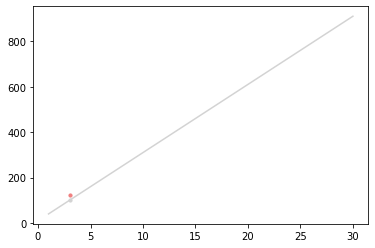

In [12]:
predictor = "stddev"
target = "prediction"
    
# Create plotting area
fig = plt.plot(figsize=(10,3.75))
ax = plt.gca()

# Scatterplots
plot_means(df_over, predictor, target, "lightgrey", ax)
plot_means(df_under, predictor, target, "lightcoral", ax)

# Curve fits
line_x = np.linspace(1,30)
plot_linear_ols(df_over, predictor, target, "lightgrey", ax, line_x)
plot_log_ols(df_under, predictor, target, "lightcoral", ax, line_x)

# Axis labels
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Prediction')

# y-Axis range
ax.set_ylim([78, 102])

# Save result
plt.savefig(figure_path + "stddev_prediction", dpi = 200, bbox_inches = 'tight')

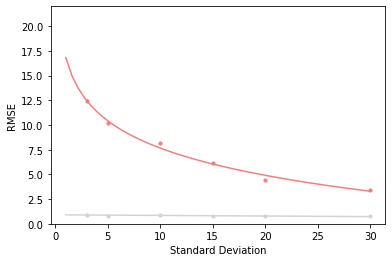

In [54]:
predictor = "stddev"
target = "rmse"
    
# Create plotting area
fig = plt.plot(figsize=(10,3.75))
ax = plt.gca()

# Scatterplots
plot_means(df_over, predictor, target, "lightgrey", ax)
plot_means(df_under, predictor, target, "lightcoral", ax)

# Curve fits
line_x = np.linspace(1,30)
plot_linear_ols(df_over, predictor, target, "lightgrey", ax, line_x)
plot_log_ols(df_under, predictor, target, "lightcoral", ax, line_x)

# Axis labels
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('RMSE')

# y-Axis range
ax.set_ylim([0, 22])

# Save result
plt.savefig(figure_path + "stddev_rmse", dpi = 200, bbox_inches = 'tight')

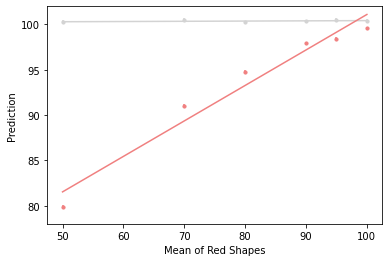

In [45]:
predictor = "mean_red"
target = "prediction"
    
# Create plotting area
fig = plt.plot(figsize=(10,3.75))
ax = plt.gca()

# Scatterplots
plot_means(df_over, predictor, target, "lightgrey", ax)
plot_means(df_under, predictor, target, "lightcoral", ax)

# Curve fits
line_x = np.linspace(50,100)
plot_linear_ols(df_over, predictor, target, "lightgrey", ax, line_x)
plot_linear_ols(df_under, predictor, target, "lightcoral", ax, line_x)

# Axis labels
ax.set_xlabel('Mean of Red Shapes')
ax.set_ylabel('Prediction')

# y-Axis range
ax.set_ylim([78, 102])

# Save result
plt.savefig(figure_path + "mean_prediction", dpi = 200, bbox_inches = 'tight')

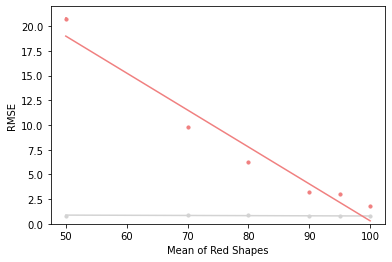

In [52]:
predictor = "mean_red"
target = "rmse"
    
# Create plotting area
fig = plt.plot(figsize=(10,3.75))
ax = plt.gca()

# Scatterplots
plot_means(df_over, predictor, target, "lightgrey", ax)
plot_means(df_under, predictor, target, "lightcoral", ax)

# Curve fits
line_x = np.linspace(50,100)
plot_linear_ols(df_over, predictor, target, "lightgrey", ax, line_x)
plot_linear_ols(df_under, predictor, target, "lightcoral", ax, line_x)

# Axis labels
ax.set_xlabel('Mean of Red Shapes')
ax.set_ylabel('RMSE')

# y-Axis range
ax.set_ylim([0, 22])

# Save result
plt.savefig(figure_path + "mean_rmse", dpi = 200, bbox_inches = 'tight')

<ipython-input-40-d7a138f75d74>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["transformed_" + predictor] = 1 / df[predictor]


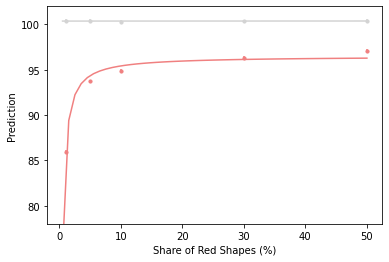

In [47]:
predictor = "minority_share"
target = "prediction"
    
# Create plotting area
fig = plt.plot(figsize=(10,3.75))
ax = plt.gca()

# Scatterplots
plot_means(df_over, predictor, target, "lightgrey", ax)
plot_means(df_under, predictor, target, "lightcoral", ax)

# Curve fits
line_x = np.linspace(0.5,50)
plot_linear_ols(df_over, predictor, target, "lightgrey", ax, line_x)
#plot_log_ols(df_under, predictor, target, "lightcoral", ax, line_x)
plot_reciprocal_ols(df_under, predictor, target, "lightcoral", ax, line_x)

# Axis labels
ax.set_xlabel('Share of Red Shapes (%)')
ax.set_ylabel('Prediction')

# y-Axis range
ax.set_ylim([78, 102])

# Save result
plt.savefig(figure_path + "share_prediction", dpi = 200, bbox_inches = 'tight')

<ipython-input-40-d7a138f75d74>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["transformed_" + predictor] = 1 / df[predictor]


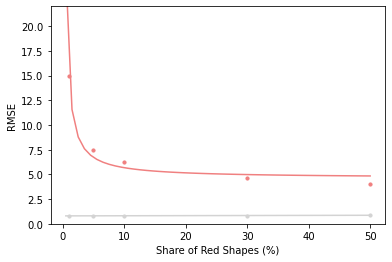

In [48]:
predictor = "minority_share"
target = "rmse"
    
# Create plotting area
fig = plt.plot(figsize=(10,3.75))
ax = plt.gca()

# Scatterplots
plot_means(df_over, predictor, target, "lightgrey", ax)
plot_means(df_under, predictor, target, "lightcoral", ax)

# Curve fits
line_x = np.linspace(0.5,50)
plot_linear_ols(df_over, predictor, target, "lightgrey", ax, line_x)
plot_reciprocal_ols(df_under, predictor, target, "lightcoral", ax, line_x)

# Axis labels
ax.set_xlabel('Share of Red Shapes (%)')
ax.set_ylabel('RMSE')

# y-Axis range
ax.set_ylim([0, 22])

# Save result
plt.savefig(figure_path + "share_rmse", dpi = 200, bbox_inches = 'tight')

## Interactions

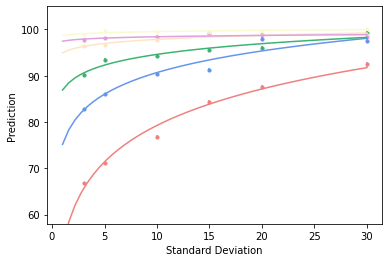

In [21]:
predictor = "stddev"
target = "prediction"

# Set colors
colors = {
    50: "lightcoral", 
    70: "cornflowerblue", 
    80: "mediumseagreen", 
    90: "bisque", 
    95: "plum", 
    100: "lightgoldenrodyellow"
}

# Create plotting area
fig = plt.plot(figsize=(10,3.75))
ax = plt.gca()

grouped = df_under.groupby(df_under.mean_red)
for mean_red in grouped.groups.keys():
    # Get data
    data = grouped.get_group(mean_red)
    
    # Plot means
    plot_means(data, predictor, target, colors[mean_red], ax)

    # Curve fits
    line_x = np.linspace(1,30)
    plot_log_ols(data, predictor, target, colors[mean_red], ax, line_x, mean_red)

# Axis labels
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Prediction')

# y-Axis range
ax.set_ylim([58, 105])

# Legend
#ax.legend()

# Save result
plt.savefig(figure_path + "stddev_mean_interaction_prediction", dpi = 200, bbox_inches = 'tight')

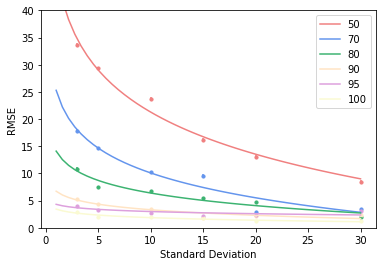

In [72]:
predictor = "stddev"
target = "rmse"

# Set colors
colors = {
    50: "lightcoral", 
    70: "cornflowerblue", 
    80: "mediumseagreen", 
    90: "bisque", 
    95: "plum", 
    100: "lightgoldenrodyellow"
}

# Create plotting area
fig = plt.plot(figsize=(10,3.75))
ax = plt.gca()

grouped = df_under.groupby(df_under.mean_red)
for mean_red in grouped.groups.keys():
    # Get data
    data = grouped.get_group(mean_red)
    
    # Plot means
    plot_means(data, predictor, target, colors[mean_red], ax)

    # Curve fits
    line_x = np.linspace(1,30)
    plot_log_ols(data, predictor, target, colors[mean_red], ax, line_x, mean_red)

# Axis labels
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('RMSE')

# y-Axis range
ax.set_ylim([0, 40])

# Legend
ax.legend()

# Save result
plt.savefig(figure_path + "stddev_mean_interaction_rmse", dpi = 200, bbox_inches = 'tight')

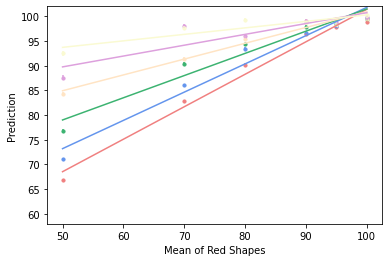

In [78]:
predictor = "mean_red"
target = "prediction"

# Set colors
colors = {
    3: "lightcoral", 
    5: "cornflowerblue", 
    10: "mediumseagreen", 
    15: "bisque", 
    20: "plum", 
    30: "lightgoldenrodyellow"
}

# Create plotting area
fig = plt.plot(figsize=(10,3.75))
ax = plt.gca()

grouped = df_under.groupby(df_under.stddev)
for mean_red in grouped.groups.keys():
    # Get data
    data = grouped.get_group(mean_red)
    
    # Plot means
    plot_means(data, predictor, target, colors[mean_red], ax)

    # Curve fits
    line_x = np.linspace(50,100)
    plot_linear_ols(data, predictor, target, colors[mean_red], ax, line_x, mean_red)

# Axis labels
ax.set_xlabel('Mean of Red Shapes')
ax.set_ylabel('Prediction')

# y-Axis range
ax.set_ylim([58, 102])

# Legend
#ax.legend()

# Save result
plt.savefig(figure_path + "stddev_mean_interaction_prediction_reversed", dpi = 200, bbox_inches = 'tight')

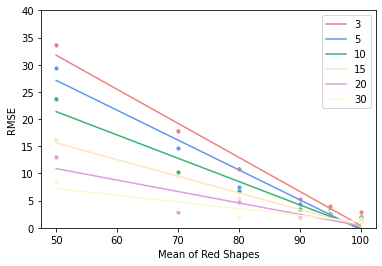

In [79]:
predictor = "mean_red"
target = "rmse"

# Set colors
colors = {
    3: "lightcoral", 
    5: "cornflowerblue", 
    10: "mediumseagreen", 
    15: "bisque", 
    20: "plum", 
    30: "lightgoldenrodyellow"
}

# Create plotting area
fig = plt.plot(figsize=(10,3.75))
ax = plt.gca()

grouped = df_under.groupby(df_under.stddev)
for mean_red in grouped.groups.keys():
    # Get data
    data = grouped.get_group(mean_red)
    
    # Plot means
    plot_means(data, predictor, target, colors[mean_red], ax)

    # Curve fits
    line_x = np.linspace(50,100)
    plot_linear_ols(data, predictor, target, colors[mean_red], ax, line_x, mean_red)

# Axis labels
ax.set_xlabel('Mean of Red Shapes')
ax.set_ylabel('RMSE')

# y-Axis range
ax.set_ylim([0, 40])

# Legend
ax.legend()

# Save result
plt.savefig(figure_path + "stddev_mean_interaction_rmse_reversed", dpi = 200, bbox_inches = 'tight')

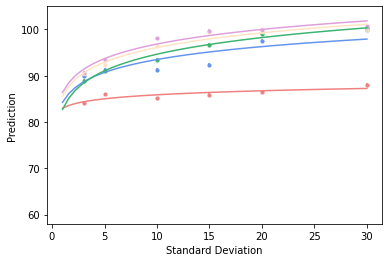

In [19]:
predictor = "stddev"
target = "prediction"

# Set colors
colors = {
    1: "lightcoral", 
    5: "cornflowerblue", 
    10: "mediumseagreen", 
    30: "bisque", 
    50: "plum", 
    100: "lightgoldenrodyellow"
}

# Create plotting area
fig = plt.plot(figsize=(10,3.75))
ax = plt.gca()

grouped = df_under.groupby(df_under.minority_share)
for minority_share in grouped.groups.keys():
    # Get data
    data = grouped.get_group(minority_share)
    
    # Plot means
    plot_means(data, predictor, target, colors[minority_share], ax)

    # Curve fits
    line_x = np.linspace(1,30)
    plot_log_ols(data, predictor, target, colors[minority_share], ax, line_x, minority_share)

# Axis labels
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Prediction')

# y-Axis range
ax.set_ylim([58, 105])

# Legend
#ax.legend()

# Save result
plt.savefig(figure_path + "stddev_share_interaction_prediction", dpi = 200, bbox_inches = 'tight')

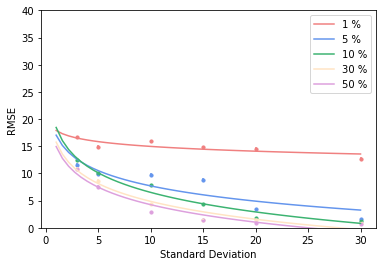

In [28]:
predictor = "stddev"
target = "rmse"

# Set colors
colors = {
    1: "lightcoral", 
    5: "cornflowerblue", 
    10: "mediumseagreen", 
    30: "bisque", 
    50: "plum", 
    100: "lightgoldenrodyellow"
}

# Create plotting area
fig = plt.plot(figsize=(10,3.75))
ax = plt.gca()

grouped = df_under.groupby(df_under.minority_share)
for minority_share in grouped.groups.keys():
    # Get data
    data = grouped.get_group(minority_share)
    
    # Plot means
    plot_means(data, predictor, target, colors[minority_share], ax)

    # Curve fits
    line_x = np.linspace(1,30)
    plot_log_ols(data, predictor, target, colors[minority_share], ax, line_x, str(minority_share) + " %")

# Axis labels
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('RMSE')

# y-Axis range
ax.set_ylim([0, 40])

# Legend
ax.legend()

# Save result
plt.savefig(figure_path + "stddev_share_interaction_rmse", dpi = 200, bbox_inches = 'tight')

# Analysis - Experiment 2: Distractor + Model Size

In [4]:
df = load_run_data(run = "regression_model_distractor", date = "04-05-2021", results_path = results_path)
df

,Unnamed: 0,run,date,model,loss,category,m_diff,stddev,minority_share,repeat,shape_color,shape_type,actual,prediction,group,prediction_diff,rmse
0,0,regression_model_distractor,2021-05-04 17:23:58.397,SmallCNN,mse,color,50,3,50,1,white,square,115,114.900444,over,-0.099556,0.099556
1,1,regression_model_distractor,2021-05-04 17:23:58.397,SmallCNN,mse,color,50,3,50,1,white,square,127,125.677490,over,-1.322510,1.322510
2,2,regression_model_distractor,2021-05-04 17:23:58.397,SmallCNN,mse,color,50,3,50,1,white,square,113,113.279274,over,0.279274,0.279274
3,3,regression_model_distractor,2021-05-04 17:23:58.397,SmallCNN,mse,color,50,3,50,1,white,square,107,107.164261,over,0.164261,0.164261
4,4,regression_model_distractor,2021-05-04 17:23:58.397,SmallCNN,mse,color,50,3,50,1,white,square,92,92.038467,over,0.038467,0.038467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29995,regression_model_distractor,2021-05-04 17:23:58.397,MiniCNN,mse,shape,50,3,50,10,colorful,circle,77,68.449554,under,-8.550446,8.550446
29996,29996,regression_model_distractor,2021-05-04 17:23:58.397,MiniCNN,mse,shape,50,3,50,10,colorful,circle,84,75.360352,under,-8.639648,8.639648
29997,29997,regression_model_distractor,2021-05-04 17:23:58.397,MiniCNN,mse,shape,50,3,50,10,colorful,circle,102,92.039246,under,-9.960754,9.960754
29998,29998,regression_model_distractor,2021-05-04 17:23:58.397,MiniCNN,mse,shape,50,3,50,10,colorful,circle,108,93.799706,under,-14.200294,14.200294


In [6]:
# Pretty print model size and add custom ordering
conditions = [
    (df['model'] == "SimpleCNN"),
    (df['model'] == "SmallCNN"),
    (df['model'] == "MiniCNN")
]

values = ['large', 'base', 'small']

# Applying custom categorical order
labels = ['small','base','large']

df['model_size'] = pd.Categorical(np.select(conditions, values), categories = labels , ordered = True)
df['model_size_int'] = np.select(conditions, [3, 2, 1])

In [11]:
results = []

# Group data
predictors = ["category", "model_size"]
grouped = df.groupby(predictors)

# Go through groups
for category, model_size in grouped.groups.keys():
    
    # Get data
    data = grouped.get_group((category, model_size))
    
    # Overall data
    avg_prediction, avg_rmse = get_results(data)
    
    # White shapes
    white_shapes = data[data.group == "over"]
    avg_prediction_w, avg_rmse_w = get_results(white_shapes)
    
    # Red shapes
    red_shapes = data[data.group == "under"]
    avg_prediction_r, avg_rmse_r = get_results(red_shapes)
    
    # Perform KS-Test
    ks_stat, ks_p = ks_2samp(white_shapes.prediction, red_shapes.prediction)
        
    # Store data
    results.append(
        {
            "category": category,      
            "model": model_size,
            "count": data.shape[0],
            "avg_prediction_w": avg_prediction_w,
            "avg_prediction_r": avg_prediction_r,
            "avg_rmse_w": avg_rmse_w,
            "avg_rmse_r": avg_rmse_r,    
            "ks_stat": ks_stat,
            "ks_p": ks_p,
            "prediction_diff": avg_prediction_w - avg_prediction_r,
            "rmse_diff": avg_rmse_w - avg_rmse_r
            
        }
    )
    
# Make dataframe of results
df_results = pd.DataFrame(results)
df_results

,category,model,count,avg_prediction_w,avg_prediction_r,avg_rmse_w,avg_rmse_r,ks_stat,ks_p,prediction_diff,rmse_diff
0,color,base,5000,101.335224,70.276959,1.179227,30.155041,0.7736,0.000000e+00,31.058265,-28.975814
1,color,large,5000,99.985763,73.385529,1.397744,27.046471,0.6840,0.000000e+00,26.600234,-25.648727
2,color,small,5000,101.167246,65.773814,3.561420,34.658186,0.8412,0.000000e+00,35.393432,-31.096766
3,shape,base,5000,100.937524,88.855695,0.749479,11.576305,0.3500,2.942586e-136,12.081829,-10.826826
4,shape,large,5000,100.421643,88.277583,0.782245,12.156379,0.3644,6.117705e-148,12.144060,-11.374134
5,shape,small,5000,100.700796,90.335500,3.685908,10.096572,0.3908,1.038469e-170,10.365297,-6.410664


In [12]:
# Print table to LaTeX format
for index, row in df_results.iterrows():
    distractor = row["category"]
    model = row["model"]
    mean_w = row["avg_prediction_w"]
    rmse_w = row["avg_rmse_w"]
    mean_r = row["avg_prediction_r"]
    rmse_r = row["avg_rmse_r"]
    ks_stat = row["ks_stat"]
    if row["ks_p"] != 0.0:
        ks_p = convert_p_val_to_str(row["ks_p"])
    else:
        ks_p = "0.0000"
    prediction_diff = row["prediction_diff"]
    rmse_diff = row["rmse_diff"]
    print("{} & {} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {} & {:.2f} & {:.2f} \\\\".format(distractor, model, mean_w, rmse_w, mean_r, rmse_r, ks_stat, ks_p, prediction_diff, rmse_diff))

color & base & 101.34 & 1.18 & 70.28 & 30.16 & 0.77 & 0.0000 & 31.06 & -28.98 \\
color & large & 99.99 & 1.40 & 73.39 & 27.05 & 0.68 & 0.0000 & 26.60 & -25.65 \\
color & small & 101.17 & 3.56 & 65.77 & 34.66 & 0.84 & 0.0000 & 35.39 & -31.10 \\
shape & base & 100.94 & 0.75 & 88.86 & 11.58 & 0.35 & $2.94\times10^{-136}$ \tnote{****} & 12.08 & -10.83 \\
shape & large & 100.42 & 0.78 & 88.28 & 12.16 & 0.36 & $6.12\times10^{-148}$ \tnote{****} & 12.14 & -11.37 \\
shape & small & 100.70 & 3.69 & 90.34 & 10.10 & 0.39 & $1.04\times10^{-170}$ \tnote{****} & 10.37 & -6.41 \\


In [13]:
df_under = df[df.group == "under"]

predictors = ["category", "model_size_int"]

# Initialize all combinations for OLS regression to test for interactions
ols_predictors = ""
for predictor in predictors:
    ols_predictors = ols_predictors + predictor + " + " 
ols_predictors = ols_predictors + "category * model_size_int"

# Define targets
targets = ["prediction", "rmse"]

# Create empty dataframe for OLS results
ols_df = pd.DataFrame()

for target in targets:
    model = ols('{} ~ {}'.format(target, ols_predictors), df_under).fit()
    ols_df["{}_coef".format(target)] = model.params
    ols_df["{}_t".format(target)] = model.tvalues
    ols_df["{}_p".format(target)] = model.pvalues

ols_df

,prediction_coef,prediction_t,prediction_p,rmse_coef,rmse_t,rmse_p
Intercept,62.200385,165.586379,0.000000e+00,38.231615,140.930665,0.000000e+00
category[T.shape],29.013791,54.616141,0.000000e+00,-29.015003,-75.629371,0.000000e+00
model_size_int,3.805858,21.887061,1.484719e-104,-3.805858,-30.306709,7.135193e-196
category[T.shape]:model_size_int,-4.834816,-19.660741,5.485111e-85,4.835761,27.229277,2.138605e-159


In [14]:
# Print table to LaTeX
latex_df = ols_df.reset_index()

# Get targets
target_0 = targets[0]
target_1 = targets[1]

# Check number of interactions
latex_df["interaction_level"] = latex_df["index"].str.count(":")

# Format interaction column for latex export
latex_df["index"] = latex_df["index"].str.replace(":", " $\\times$ ", regex = False)

# Format coefficients
latex_df[target_0 + "_coef"] = latex_df[target_0 + "_coef"].apply(lambda x: convert_val_to_str(x))
latex_df[target_1 + "_coef"] = latex_df[target_1 + "_coef"].apply(lambda x: convert_val_to_str(x))

# Format t values
latex_df[target_0 + "_t"] = latex_df[target_0 + "_t"].apply(lambda x: convert_val_to_str(x))
latex_df[target_1 + "_t"] = latex_df[target_1 + "_t"].apply(lambda x: convert_val_to_str(x))

# Get significance
latex_df[target_0 + "_sign"] = latex_df[target_0 + "_p"].apply(lambda p: get_significance_string_latex(p))
latex_df[target_1 + "_sign"] = latex_df[target_1 + "_p"].apply(lambda p: get_significance_string_latex(p))

# Format p values
latex_df[target_0 + "_p"] = latex_df[target_0 + "_p"].apply(lambda p: convert_p_val_to_str(p))
latex_df[target_1 + "_p"] = latex_df[target_1 + "_p"].apply(lambda p: convert_p_val_to_str(p))

# Sort by number of interactions
latex_df.sort_values("interaction_level", inplace = True)

for index, row in latex_df.iterrows():
    print("{} & {} {} & {} {} \\\\".format(row["index"], row[target_0 + "_coef"], row[target_0 + "_sign"], row[target_1 + "_coef"], row[target_1 + "_sign"]))

Intercept & 62.2004 \tnote{****} & 38.2316 \tnote{****} \\
category[T.shape] & 29.0138 \tnote{****} & -29.0150 \tnote{****} \\
model_size_int & 3.8059 \tnote{****} & -3.8059 \tnote{****} \\
category[T.shape] $\times$ model_size_int & -4.8348 \tnote{****} & 4.8358 \tnote{****} \\


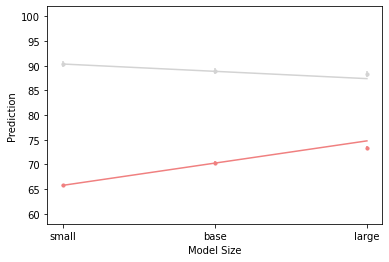

In [158]:
predictor = "model_size"
target = "prediction"

# Set colors
colors = {
    "color": "lightcoral", 
    "shape": "lightgrey"
}

# Create plotting area
fig = plt.plot(figsize=(10,3.75))
ax = plt.gca()

grouped = df_under.groupby(df_under.category)
for category in grouped.groups.keys():
    # Get data
    data = grouped.get_group(category)
    
    # Plot means
    plot_means(data, predictor, target, colors[category], ax)

    # Curve fits
    line_x = np.linspace(0,2)
    plot_linear_ols(data, predictor, target, colors[category], ax, line_x, category)

# Axis labels
ax.set_xlabel('Model Size')
ax.set_ylabel('Prediction')

# y-Axis range
ax.set_ylim([58, 102])

# Legend
#ax.legend()

# Save result
plt.savefig(figure_path + "distractor_model_interaction_prediction", dpi = 200, bbox_inches = 'tight')

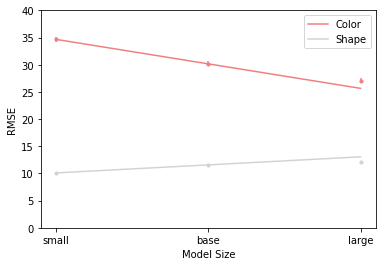

In [157]:
predictor = "model_size"
target = "rmse"

# Set colors
colors = {
    "color": "lightcoral", 
    "shape": "lightgrey"
}

# Create plotting area
fig = plt.plot(figsize=(10,3.75))
ax = plt.gca()

grouped = df_under.groupby(df_under.category)
for category in grouped.groups.keys():
    # Get data
    data = grouped.get_group(category)
    
    # Plot means
    plot_means(data, predictor, target, colors[category], ax)

    # Curve fits
    line_x = np.linspace(0,2)
    plot_linear_ols(data, predictor, target, colors[category], ax, line_x, category.title())

# Axis labels
ax.set_xlabel('Model Size')
ax.set_ylabel('RMSE')

# y-Axis range
ax.set_ylim([0, 40])

# Legend
ax.legend()

# Save result
plt.savefig(figure_path + "distractor_model_interaction_rmse", dpi = 200, bbox_inches = 'tight')

### Individual Plots

In [62]:
def plot_means(df, predictor, target, color, ax):    
    # Get 95% confidence intervals of means
    stats = df.groupby([predictor])[target].agg(['mean', 'count', 'std'])
    ci95_hi = []
    ci95_lo = []
    for i in stats.index:
      m, c, s = stats.loc[i]
      ci95_hi.append(m + 1.95*s/np.sqrt(c))
      ci95_lo.append(m - 1.95*s/np.sqrt(c))
    stats['ci95_hi'] = ci95_hi
    stats['ci95_lo'] = ci95_lo
    stats['grp'] = stats.index
    # Plot confidence intervals
    for grp in stats.index:
        ax.vlines(x=grp, ymin=stats.loc[grp]['ci95_lo'], ymax=stats.loc[grp]['ci95_hi'], color = color)
    # Plot means
    ax.scatter(x=stats['grp'], y=stats['mean'], s = 10, color = color)
    
def plot_ols(df, predictor, target, color, ax, line_x):
    # Plot group means
    plot_means(df, predictor, target, color, ax)
    # Fit OLS to each data group
    model = ols('{} ~ {}'.format(target, predictor), df).fit()
    # Plot OLS lines
    p = model.params
    line_y = p.Intercept + p[1] * line_x
    ax.plot(line_x, line_y, color = color)
    return line_y

def get_overlap(row):
    dist_1 = NormalDist(mu=75+row.m_diff/2, sigma=row.stddev)
    dist_2 = NormalDist(mu=75-row.m_diff/2, sigma=row.stddev)
    return dist_1.overlap(dist_2)

In [44]:
df["overlap"] = df.apply(lambda row: get_overlap(row), axis=1)

Predictor: m_diff, Target: prediction


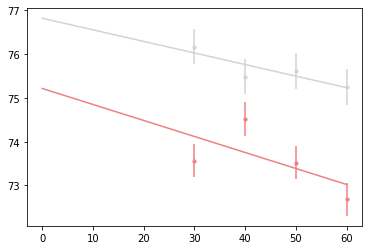

<ipython-input-74-55549c003b44>:22: RuntimeWarning: divide by zero encountered in log
  line_x = np.log(np.arange(xmin, xmax, step = 0.001))


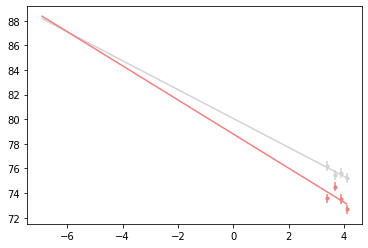

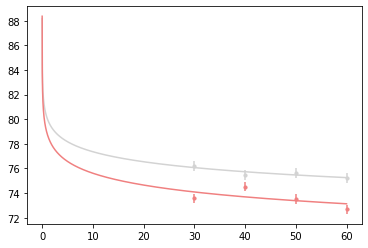

Predictor: m_diff, Target: rmse


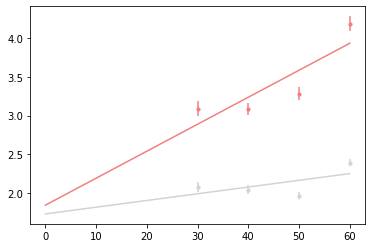

<ipython-input-74-55549c003b44>:22: RuntimeWarning: divide by zero encountered in log
  line_x = np.log(np.arange(xmin, xmax, step = 0.001))


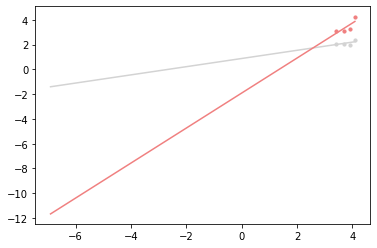

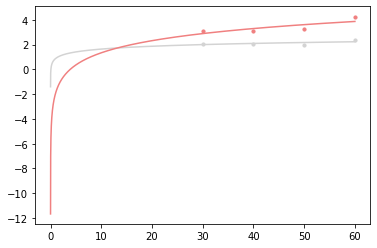

Predictor: stddev, Target: prediction


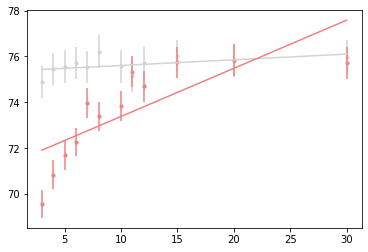

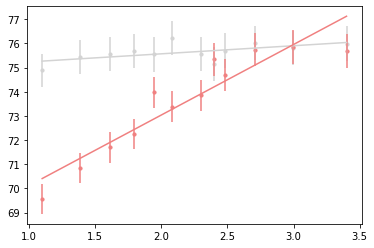

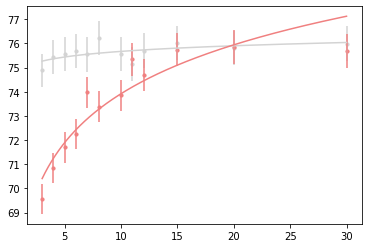

Predictor: stddev, Target: rmse


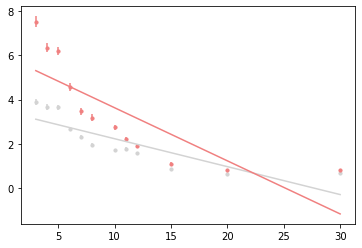

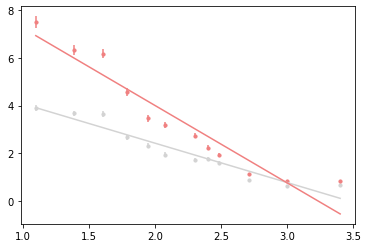

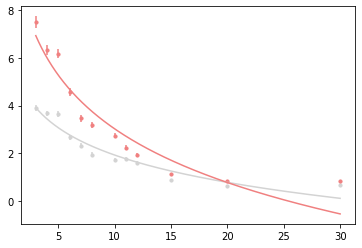

Predictor: overlap, Target: prediction


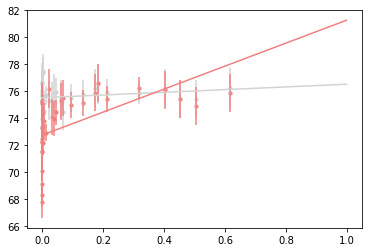

<ipython-input-74-55549c003b44>:22: RuntimeWarning: divide by zero encountered in log
  line_x = np.log(np.arange(xmin, xmax, step = 0.001))


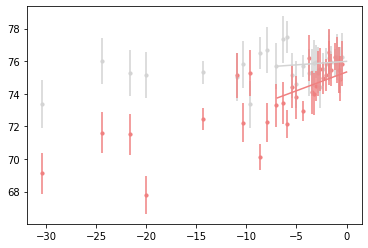

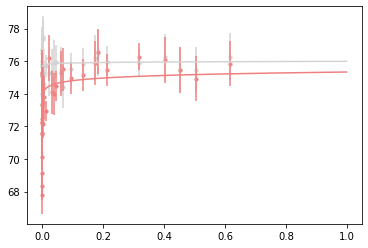

Predictor: overlap, Target: rmse


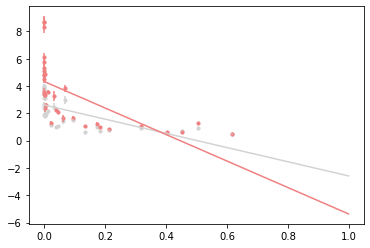

<ipython-input-74-55549c003b44>:22: RuntimeWarning: divide by zero encountered in log
  line_x = np.log(np.arange(xmin, xmax, step = 0.001))


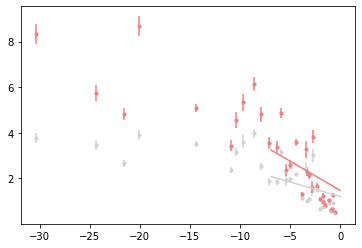

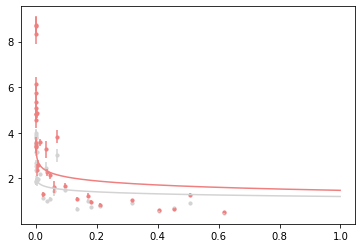

In [74]:
for predictor in predictors:
    for target in targets:
        # Print combination
        print("Predictor: {}, Target: {}".format(predictor, target))
        # Create plotting area
        fig = plt.plot(figsize=(10,3.75))
        ax = plt.gca()
        # Plot OLS for each group
        xmin, xmax = df[predictor].min(), df[predictor].max()
        line_x = np.arange(xmin, xmax, step = 0.001)
        plot_ols(df_over, predictor, target, color_over, ax, line_x)
        plot_ols(df_under, predictor, target, color_under, ax, line_x)
        # Show plot
        plt.show()
        
        # Log scale
        log_predictor = "log_" + predictor
        # Create plotting area
        fig = plt.plot(figsize=(10,3.75))
        ax = plt.gca()
        # Plot OLS for each group
        line_x = np.log(np.arange(xmin, xmax, step = 0.001))
        y_over = plot_ols(df_over, log_predictor, target, color_over, ax, line_x)
        y_under = plot_ols(df_under, log_predictor, target, color_under, ax, line_x)
        # Show plot
        plt.show()
        
        # Log scale transformed back to normal scale
        # Create plotting area
        fig = plt.plot(figsize=(10,3.75))
        ax = plt.gca()
        # Plot OLS for each group
        plot_means(df_over, predictor, target, color_over, ax)
        plot_means(df_under, predictor, target, color_under, ax)
        line_x = np.arange(xmin, xmax, step = 0.001)
        ax.plot(line_x, y_over, color = color_over)
        ax.plot(line_x, y_under, color = color_under)
        # Show plot
        plt.show()

0


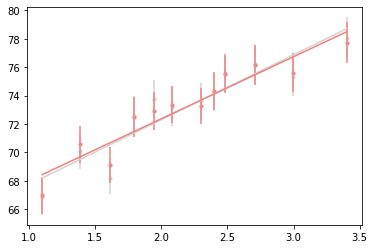

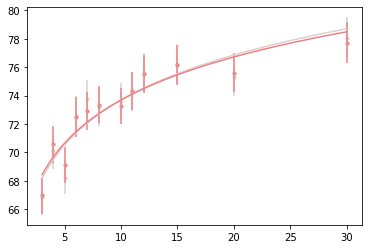

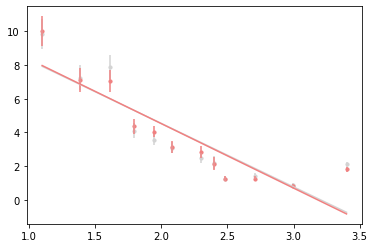

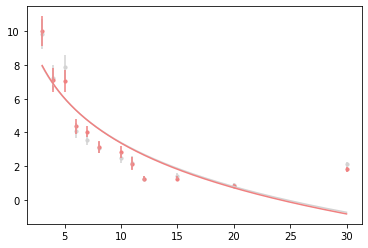

5


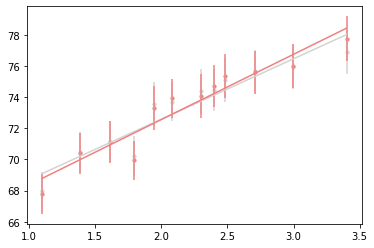

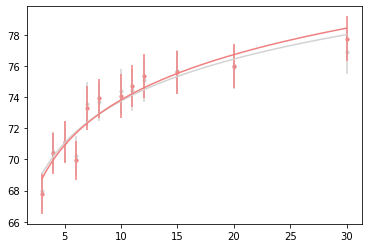

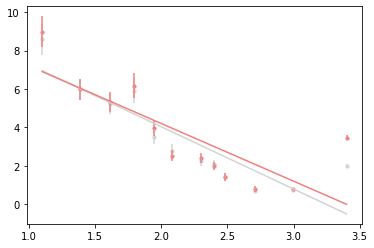

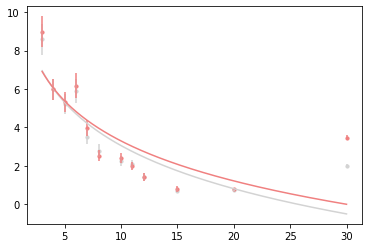

10


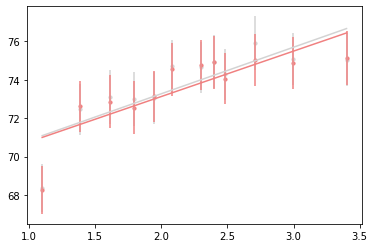

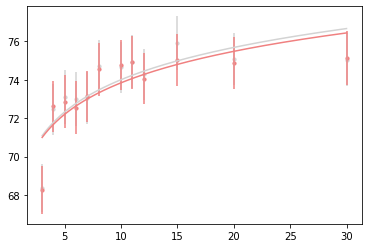

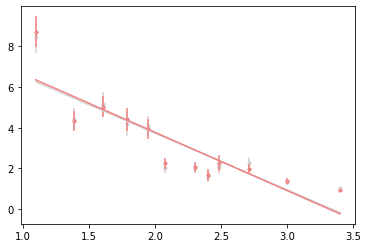

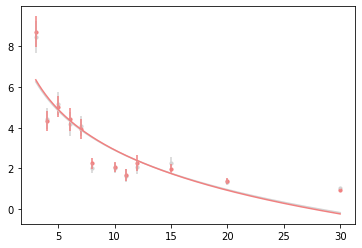

15


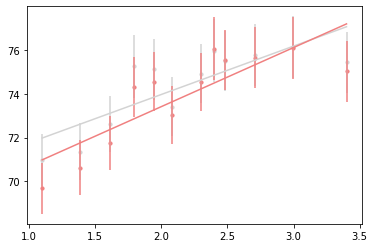

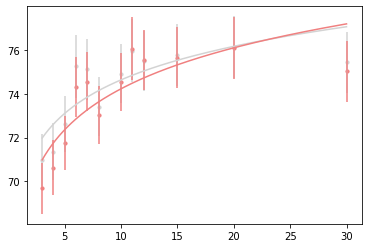

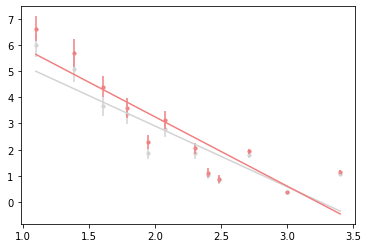

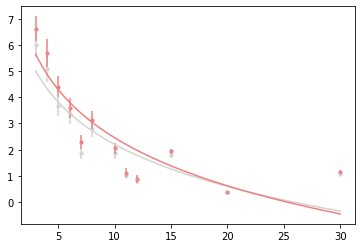

20


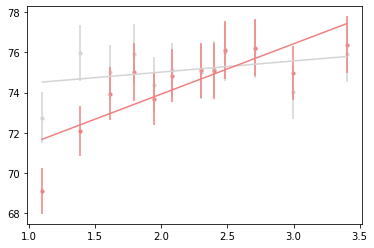

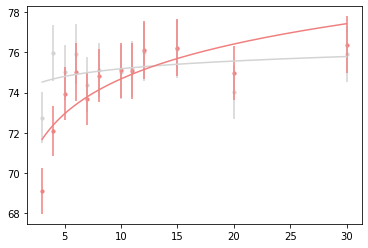

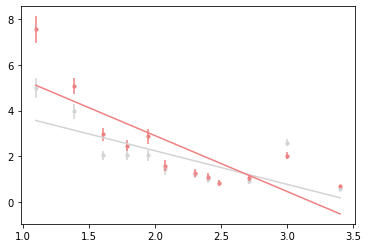

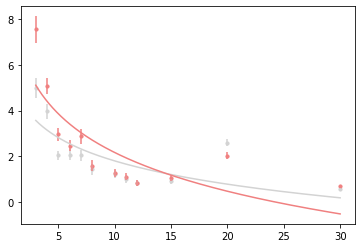

30


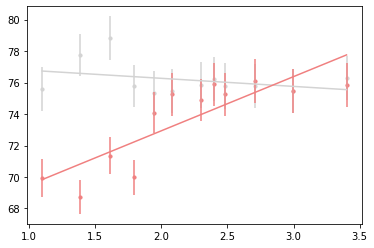

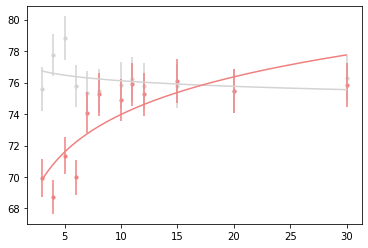

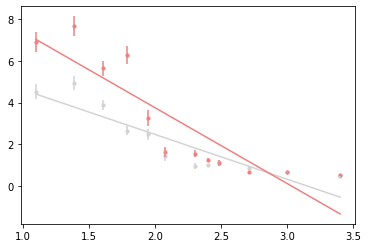

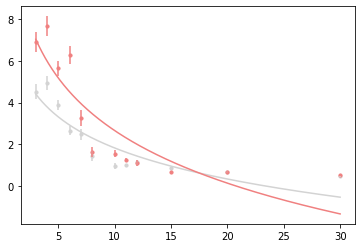

40


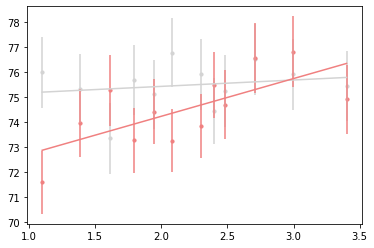

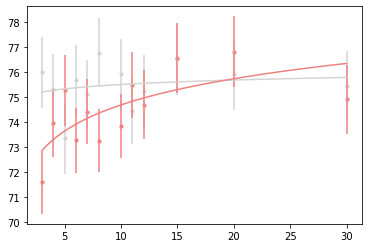

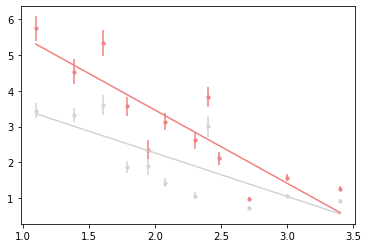

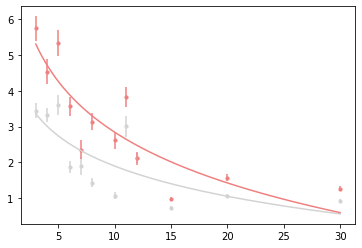

50


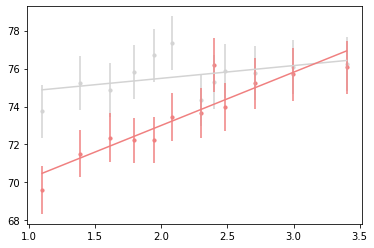

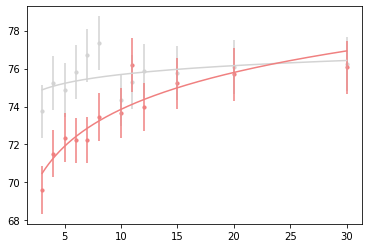

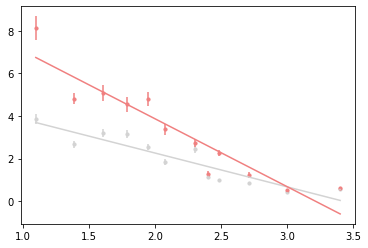

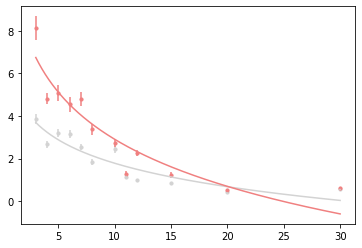

60


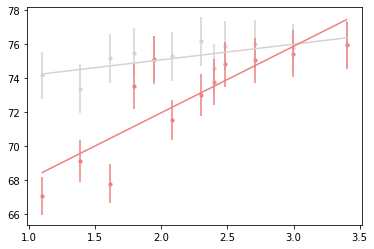

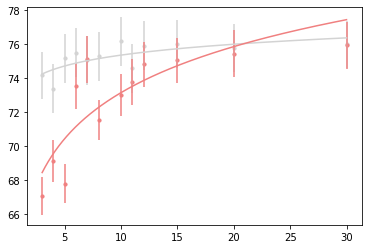

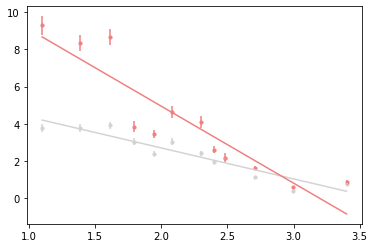

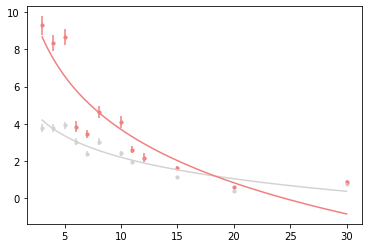

In [84]:
# TODO stddev curve by meandiff
predictor = "stddev"
grouped_over = df_over.groupby(df.m_diff)
grouped_under = df_under.groupby(df.m_diff)
for group in grouped_over.groups.keys():
    print(group)
    for target in targets:
        data_over = grouped_over.get_group(group)
        data_under = grouped_under.get_group(group)
        
        xmin, xmax = df[predictor].min(), df[predictor].max()
        # Log scale
        log_predictor = "log_" + predictor
        # Create plotting area
        fig = plt.plot(figsize=(10,3.75))
        ax = plt.gca()
        # Plot OLS for each group
        line_x = np.log(np.arange(xmin, xmax, step = 0.001))
        y_over = plot_ols(data_over, log_predictor, target, color_over, ax, line_x)
        y_under = plot_ols(data_under, log_predictor, target, color_under, ax, line_x)
        # Show plot
        plt.show()

        # Log scale transformed back to normal scale
        # Create plotting area
        fig = plt.plot(figsize=(10,3.75))
        ax = plt.gca()
        # Plot OLS for each group
        plot_means(data_over, predictor, target, color_over, ax)
        plot_means(data_under, predictor, target, color_under, ax)
        line_x = np.arange(xmin, xmax, step = 0.001)
        ax.plot(line_x, y_over, color = color_over)
        ax.plot(line_x, y_under, color = color_under)
        # Show plot
        plt.show()

In [10]:
model = ols('prediction ~ {}'.format(predictor, df_over).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             prediction   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     168.0
Date:                Fri, 19 Mar 2021   Prob (F-statistic):           2.17e-38
Time:                        18:51:15   Log-Likelihood:            -6.2679e+05
No. Observations:              135000   AIC:                         1.254e+06
Df Residuals:                  134998   BIC:                         1.254e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     73.3782      0.122    602.601      0.0

In [12]:
model.params

Intercept    73.378161
stddev        0.119609
dtype: float64

## Predictions

## Predictions

### General OLS

In [66]:
model = ols('prediction ~ m_diff + log_stddev + group + overlap + overlap * group + log_stddev * group + m_diff * group + log_stddev * m_diff + log_stddev * m_diff * group', df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             prediction   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     187.7
Date:                Sat, 20 Mar 2021   Prob (F-statistic):               0.00
Time:                        09:58:21   Log-Likelihood:            -1.2481e+06
No. Observations:              270000   AIC:                         2.496e+06
Df Residuals:                  269990   BIC:                         2.496e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [67]:
model = ols('rmse ~ m_diff + log_stddev + group + overlap + overlap * group + log_stddev * group + m_diff * group + log_stddev * m_diff + log_stddev * m_diff * group', df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   rmse   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     3071.
Date:                Sat, 20 Mar 2021   Prob (F-statistic):               0.00
Time:                        11:13:43   Log-Likelihood:            -8.6269e+05
No. Observations:              270000   AIC:                         1.725e+06
Df Residuals:                  269990   BIC:                         1.725e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep